<a href="https://colab.research.google.com/github/sds-capstone/2022-09-proj7-women-at-table/blob/main/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Access to Emergency Funds in Sub-Saharan Countries: A Human Rights-Based Approach

# Introduction
Science is often viewed as a way to offer trustworthy research backed solutions and answers. A lot of that research involves statistical methods performed on data. However, what happens when the data and statistical methods are not as objective and trustworthy as is so often assumed? The conclusions drawn from the data are biased and unfair, most often towards minorities and protected classes of people. To contribute to a human rights based approach to data analysis, we evaluate fairness metrics on a machine learning algorithm to measure bias. We use a Global Findex data set which contains financial information about 35 Sub Saharan countries. Specifically, we create a model to predict access to emergency funds, then analyze the fairness of the model. We focus on group and individual fairness metrics for the protected attribute sex. In addition we investigate the data set itself to understand where potential biases might have been implanted. 

Data sets and algorithms have real world impacts on real people. The inherent bias in data sets can carry over into machine learning algorithms that are used to profile and categorize people. Since data set's are not collected in a vacuum and often represent the discriminatory environments in which they are collected, we must find ways to make data sets and statistical methods more equitable. In this study we explore fairness methods that can be used to evaluate machine learning models. The “impossibility theorem” is the idea that not all fairness metrics can be satisfied at the same time. Although fairness is complex and there are multiple approaches to make a model fair, it's important to continue to question how data and algorithms can be biased and how to mitigate that bias. 

## Objectives
- assess how biased our data is/understand our data
- implement machine learning models to predict access to emergency funds
- assess those machine learning models using fairness metrics

# Data

This analysis will center around predicting whether or not an individual has access to emergency funds based on other financial and demographic characteristics of the individual present in a publicly available dataset published by The World Bank in the Global Findex Database. The Global Findex Database is one of the most comprehensive data sets on how adults save, borrow, make payments, and manage risk in more than 140 economies around the world. It was initially created in 2011 in order to measure financial inclusion and promote improvements in the same. It has been updated in 2014 and 2017 ([Source](https://microdata.worldbank.org/index.php/collections/global-findex)). The main purpose the data set was created for was to record various measures of financial equity and inclusion such that the information can reveal opportunities to expand access to financial services and to promote greater use of digital financial services for folks who do not have a bank account
([Source](https://microdata.worldbank.org/index.php/collections/global-findex)).

The data set was created by the Development Research Group, Finance and Private Sector Development Unit of [The World Bank](https://www.worldbank.org/en/publication/globalfindex) with funding from Bill & Melinda Gates Foundation. The survey was conducted by Gallup, Inc in association with the annual Gallup World Poll.

The data was constructed by randomly sampling 1000 individuals from each country and asking them to respond to a survey either over the phone or in-person. We are restricting our analysis to only the Sub-Saharan region (35 countries total), thus there are 35,000 total observations in our data set. There are 105 total variables. Since the sampling was random and the sample size is large, we can assume that our sample is representative of the total population of people living in the 35 Sub-Saharan countries in the data. The data was collected directly from individuals over the 2017 calendar year and is self-contained, meaning it does not rely on any external resources.

The purpose of this notebook is primarily educational, and the results of the analysis will not have any direct real-world impacts. However, we can imagine that this same type of analysis could be used in two relatively common scenarios (and possibly others as well that we are not thinking of):

1. Predicting access to funds in order to decide whether or not to offer a loan to an individual.

It is common practice among financial institutions to use algorithms to predict how likely each applicant is to pay back a loan before agreeing to lend money. Whether or not an individual has access to emergency funds could provide information about whether or not that individual would be able to pay back a loan. If they do not have access, that may indicate that they are less likely to have money to pay back the loan.

2. Predicting access to funds in order to decide whether or not to offer financial assistance to an individual.

Another plausible scenario is that a government financial assistance program wants to predict who of their citizens have access to emergency funds so that they can provide those who do not have access with funds in the case of an emergency.

We will refer back to these two potential scenarios throughout the analysis when considering how our choices of fairness metrics and processing algorithms would impact those who would be affected by the predictions that our model outputs. It is essential to keep in mind these potential real-world impacts when choosing methods to improve the fairness of the model. 

# Setup

In [52]:
%%capture
#@title Import statements and Dependencies

# install dependencies
!pip install aif360;
!pip install fairlearn;


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as itt

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, recall_score, precision_score

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics,tree

from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.inprocessing import MetaFairClassifier

from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets.utils import standardize_dataset
from aif360.sklearn.metrics import disparate_impact_ratio,between_group_generalized_entropy_error, average_odds_error, generalized_fpr, average_odds_difference,conditional_demographic_disparity,consistency_score
from aif360.sklearn.metrics import generalized_fnr, difference,ratio ,statistical_parity_difference, equal_opportunity_difference, generalized_entropy_error

from IPython.display import Markdown, display

In [53]:
#@title Set Gender Palette
red = '#FF7377'
blue = '#00B2EE'
gender_palette = [blue, red]

purple = '#BF3EFF'
green = '#1B851B'
yes_no_pal = [purple, green]

pink = '#FFC0CB'

In [54]:
from pandas.io.formats.style import Subset
#@title Confusion matrix and Visualisation plot Function Definitions

# Function for visualising the confusion matrix and other statistics
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf_matrix, model,ax = None):
  ax = ax
  group_names = ["True Negative","False Positive","False Negative","True Positive"]
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  group_labels = ["{}\n".format(value) for value in group_names]
  group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

  box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0],cf_matrix.shape[1])


  # add more statistics
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
      accuracy,precision,recall,f1_score)


  categories=["Not Possible", "Possible"]
  sns.heatmap(cf_matrix,annot=box_labels,fmt="",cmap='Purples',xticklabels=categories,yticklabels=categories)

  plt.ylabel('True label')
  plt.xlabel('Predicted label' + stats_text)
  plt.title(f"Confusion matrix and statistics for the {model} model");

def metrics_per_group(y_test, y_pred):
	# y true per group
	y_test_male = y_test.loc[y_test.index.get_level_values(0) == 1]
	y_test_gender = y_test.loc[y_test.index.get_level_values(0) == 0]

	# y_pred per group
	y_pred_male = y_pred[y_test.index.get_level_values(0) == 1]
	y_pred_gender = y_pred[y_test.index.get_level_values(0) == 0]

	# metrics
	scores = []
	scores.append(accuracy_score(y_test, y_pred))
	scores.append(recall_score(y_test, y_pred))
	scores.append(precision_score(y_test, y_pred))

	scores.append(accuracy_score(y_test_gender, y_pred_gender))
	scores.append(recall_score(y_test_gender, y_pred_gender))
	scores.append(precision_score(y_test_gender, y_pred_gender))

	scores.append(accuracy_score(y_test_male, y_pred_male))
	scores.append(recall_score(y_test_male, y_pred_male))
	scores.append(precision_score(y_test_male, y_pred_male))

	attribute = ["all"]*3 + ["female"] *3 + ["male"] *3
	metric = ["accuracy", "recall", "precision"] * 3
	  
	# dictionary of lists 
	dict = {'gender': attribute, 'metrics': metric, 'score': scores} 
	    
	df = pd.DataFrame(dict)

	sns.barplot(x = "metrics", y = "score", hue = "gender", data = df, palette = ['#dfcd1a', '#9d0677', '#236c48'])
	plt.title("Performance metrics by groups")
 

def plot_fair_metrics(fair_metrics_mitigated, model): 
  cols = list(metrics_table.columns)[3:7]
  obj_fairness = [objective_metrics[2:6]]

    # row for objectives    
  fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
        
    # row for baseline model
  fair_metrics.loc['Baseline Model'] = baseline_metrics[2:6]

    # row for mitigated bias
  fair_metrics.loc[model] = fair_metrics_mitigated[0:4]


  metrics_len = len(cols)


  fig, ax = plt.subplots(figsize=(20,4), ncols=metrics_len, nrows=1)

  plt.subplots_adjust(
      left    =  0.125, 
      bottom  =  0.1, 
      right   =  0.9, 
      top     =  0.9, 
      wspace  =  .5, 
      hspace  =  1.1
  )

  y_title_margin = 1.2

  plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
  sns.set(style="dark")

  cols = fair_metrics.columns.values
  obj = fair_metrics.loc['objective']
  size_rect = [0.2,0.2,0.2,0.2,0.25]
  rect = [-0.1,-0.1,-0.1,-0.1,0]
  bottom = [-1,-1,-1,-1,0]
  top = [1,1,1,1,1]
  bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0,0.25]]

  for i in range(0,metrics_len):
      plt.subplot(1, metrics_len, i+1)
      ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
      for j in range(0,len(fair_metrics)-1):
          a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
          marg = -0.2 if val < 0 else 0.1
          ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

      plt.ylim(bottom[i], top[i])
      plt.setp(ax.patches, linewidth=0)
      ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
      plt.axhline(obj[i], color='black', alpha=0.3)
      plt.title(cols[i])
      ax.set_ylabel('')    
      ax.set_xlabel('')

  cols = list(metrics_table.columns)[7:11]
  obj_fairness = [objective_metrics[6:10]]

    # row for objectives    
  fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
        
    # row for baseline model
  fair_metrics.loc['Baseline Model'] = baseline_metrics[6:10]

    # row for mitigated bias
  fair_metrics.loc[model] = fair_metrics_mitigated[4:8]


  metrics_len = len(cols)


  fig, ax = plt.subplots(figsize=(20,4), ncols=metrics_len, nrows=1)

  plt.subplots_adjust(
      left    =  0.125, 
      bottom  =  0.1, 
      right   =  0.9, 
      top     =  0.9, 
      wspace  =  .5, 
      hspace  =  1.1
  )

  y_title_margin = 1.2

  #plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
  sns.set(style="dark")

  cols = fair_metrics.columns.values
  obj = fair_metrics.loc['objective']
  size_rect = [0.4,0.2,0.2,0.2,0.25]
  rect = [0.8, -0.1,-0.1,-0.1,0]
  bottom = [-1,-1,-1,-1,0]
  top = [1.6,1,1,1,1]
  bound = [[0.8,1.2], [-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0,0.25]]

  for i in range(0,metrics_len):
      plt.subplot(1, metrics_len, i+1)
      ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
      for j in range(0,len(fair_metrics)-1):
          a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
          marg = -0.2 if val < 0 else 0.1
          ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

      plt.ylim(bottom[i], top[i])
      plt.setp(ax.patches, linewidth=0)
      ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
      plt.axhline(obj[i], color='black', alpha=0.3)
      plt.title(cols[i])
      ax.set_ylabel('')    
      ax.set_xlabel('')

# function to compute fairness metrics
def get_fairness_metrics(y_test, y_pred, prot_attr):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_true = y_test, y_pred = y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
  prec_diff = difference(precision_score, y_test, y_pred=y_pred, prot_attr=prot_attr, priv_group=1)
  stat_par_diff = statistical_parity_difference(y_test, y_pred, prot_attr=prot_attr)
  eq_opp_diff = equal_opportunity_difference(y_test, y_pred, prot_attr=prot_attr)
  gen_entr_error = generalized_entropy_error(y_test, y_pred, alpha=1)
  dir = disparate_impact_ratio(y_test, y_pred=y_pred, prot_attr=prot_attr, priv_group=1)
  gen_entr_diff = difference(generalized_entropy_error, y_test, y_pred=y_pred, prot_attr=prot_attr, priv_group=1)
  bet_grp_gen_entr = between_group_generalized_entropy_error(y_test, y_pred, prot_attr=prot_attr, priv_group=1)
  cond_dem_disparity = conditional_demographic_disparity(y_test, y_pred=y_pred, prot_attr=prot_attr, pos_label=1)
  return np.around([accuracy, precision, prec_diff, stat_par_diff, eq_opp_diff, gen_entr_error, dir, gen_entr_diff, bet_grp_gen_entr, cond_dem_disparity], 3)



def color_it(value):
  if value > .1 or value <-.1:
    color = "red"
  else:
    color = "green"
  return 'color: %s' % color
def color_disp(value):
  if value > .8 or value < -.8:
    color = "green"
  else:
    color = "red"
  return 'color: %s' % color
# function to color code the columns
def back_color(col):
  color = "#D6EAF8"
  return f'background-color: {color}'
  # function to format fairness metrics into a table
def generate_metrics_table(techniques, metrics):
  metrics_table = pd.DataFrame(np.array(metrics),
                   columns=['accuracy', 'precision', 'prec_diff', 'stat_par_diff', 'eq_opp_diff', 'gen_entr_error', 'disp_impact', 'gen_entr_diff', 'bet_grp_gen_entr','cond_dem_disparity'])
  metrics_table.insert(0, 'technique', techniques, True)
  metrics_table = metrics_table.style.applymap(color_it, subset =['stat_par_diff','prec_diff','eq_opp_diff', 'gen_entr_error','gen_entr_diff', 'bet_grp_gen_entr','cond_dem_disparity']).applymap(color_disp, subset =["disp_impact"]).applymap(back_color,subset = ["gen_entr_error"])
  #metrics_table = metrics_table.style.apply(highlight_greaterthan, threshold=.1, column=['stat_par_diff', 'eq_opp_diff', 'gen_entr_error'], axis=1)
  return metrics_table

In [55]:
# @title Read in Data
file = 'https://raw.githubusercontent.com/sds-capstone/2022-09-proj7-women-at-table/main/findex_SubSahAfrica.csv'
df = pd.read_csv(file, index_col=0)
print(f'There are {df.shape[0]} entries and {df.shape[1]} features')
df.head()

There are 35000 entries and 105 features


,economy,economycode,regionwb,pop_adult,wpid_random,wgt,female,age,educ,inc_q,...,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,pay_onlne,pay_onlne_mobintbuy,pay_cash,pay_cash_mobintbuy
12138,Benin,BEN,Sub-Saharan Africa (excluding high income),6211794.0,143101339,1.909609,1,60.0,1.0,1,...,4,4,4,4.0,4,5.0,0.0,NaN,0.0,NaN
12139,Benin,BEN,Sub-Saharan Africa (excluding high income),6211794.0,123998301,2.075761,1,45.0,1.0,1,...,4,4,4,4.0,3,1.0,0.0,NaN,0.0,NaN
12140,Benin,BEN,Sub-Saharan Africa (excluding high income),6211794.0,157155643,0.785666,1,27.0,3.0,4,...,4,4,4,4.0,4,2.0,1.0,1.0,0.0,0.0
12141,Benin,BEN,Sub-Saharan Africa (excluding high income),6211794.0,155618899,1.450568,2,24.0,1.0,2,...,4,4,4,4.0,3,5.0,0.0,NaN,0.0,NaN
12142,Benin,BEN,Sub-Saharan Africa (excluding high income),6211794.0,143861320,0.461588,1,22.0,1.0,5,...,4,4,4,4.0,4,5.0,0.0,NaN,0.0,NaN


In [56]:
#@title Data Cleaning
%%capture --no-display
# select vars of interest
df2 = df[['female', 'age', 'emp_in', 'account_fin', 'fin24', 'fin25', 'fin32', 'fin48', 'educ', 'economy']]
df2 = df2.query('fin24 < 3')
# Recode fin24 values
df2.loc[df2['fin24'] == 1, "fin24"] = 'Yes'
df2.loc[df2['fin24'] == 2, "fin24"] = 'No'
df2.loc[df2['fin24'] == 3, "fin24"] = 'Don\'t Know'
df2.loc[df2['fin24'] == 4, "fin24"] = 'Refuse'
# rename fin24 to has_access
df2.rename(columns = {'fin24': 'has_access'}, inplace = True)
# recode gender
df2.loc[df2['female'] == 1, "female"] = 'male'
df2.loc[df2['female'] == 2, "female"] = 'female'
df2.rename(columns = {'female': 'gender'}, inplace = True)
# recode account_fin
df2.loc[df2['account_fin'] == 0, "account_fin"] = 'No'
df2.loc[df2['account_fin'] == 1, "account_fin"] = 'Yes'
# recode emp_in
df2.loc[df2['emp_in'] == 0, "emp_in"] = 'No'
df2.loc[df2['emp_in'] == 1, "emp_in"] = 'Yes'
# Recode fin32 values: Recieved Wage Payments
df2.loc[df2['fin32'] == 1, "fin32"] = 'Yes'
df2.loc[df2['fin32'] == 2, "fin32"] = 'No'
df2.loc[df2['fin32'] == 3, "fin32"] = 'Don\'t Know'
df2.loc[df2['fin32'] == 4, "fin32"] = 'Refuse'
# recode fin48 values: National ID
df2.loc[df2['fin48'] == 1, "fin48"] = 'Yes'
df2.loc[df2['fin48'] == 2, "fin48"] = 'No'
df2.loc[df2['fin48'] == 3, "fin48"] = 'Don\'t Know'
df2.loc[df2['fin48'] == 4, "fin48"] = 'Refuse'
#recode educ values: Highest Level of Education
df2.loc[df2['educ'] == 1, "educ"] = 'Primary'
df2.loc[df2['educ'] == 2, "educ"] = 'Secondary'
df2.loc[df2['educ'] == 3, "educ"] = 'Tertiary'
df2.loc[df2['educ'] == 4, "educ"] = 'Don\'t Know'
df2.loc[df2['educ'] == 5, "educ"] = 'Refuse'
#recode fin25 values: Main Source of Emergency Funds
df2.loc[df2['fin25'] == 1, "fin25"] = 'Savings'
df2.loc[df2['fin25'] == 2, "fin25"] = 'Family, relatives, or friends'
df2.loc[df2['fin25'] == 3, "fin25"] = 'Money from working'
df2.loc[df2['fin25'] == 4, "fin25"] = 'Borrowing from a bank/employer/private lender'
df2.loc[df2['fin25'] == 5, "fin25"] = 'Selling assets'
df2.loc[df2['fin25'] == 6, "fin25"] = '(Some other source)'
df2.loc[df2['fin25'] == 7, "fin25"] = 'Don\'t Know'
df2.loc[df2['fin25'] == 8, "fin25"] = 'Refuse'
#recode fin32 values: Recieved Wage Payments
df2.loc[df2['fin32'] == 1, "fin32"] = 'Yes'
df2.loc[df2['fin32'] == 2, "fin32"] = 'No'
df2.loc[df2['fin32'] == 3, "fin32"] = 'Don\'t Know'
df2.loc[df2['fin32'] == 4, "fin32"] = 'Refuse'

df2.rename(columns = {'fin32': 'Receive Wage Payments', 'fin48': 'National ID', 'educ': 'Education', 'fin25': 'main_source_funds'}, inplace = True)
df2.head()

,gender,age,emp_in,account_fin,has_access,main_source_funds,Receive Wage Payments,National ID,Education,economy
12138,male,60.0,No,No,No,NaN,No,No,Primary,Benin
12139,male,45.0,Yes,Yes,Yes,Money from working,No,Yes,Primary,Benin
12140,male,27.0,Yes,No,Yes,Money from working,No,Yes,Tertiary,Benin
12141,female,24.0,Yes,No,Yes,"Family, relatives, or friends",No,No,Primary,Benin
12142,male,22.0,Yes,No,No,NaN,No,No,Primary,Benin


In [57]:
# set random seed
np.random.seed(44)

# Exploratory Data Analysis

Before jumping into the predictive model, we will create some plots to get a better sense of the characteristics of the population included in the data. The data identifies several sub-populations based on demographic variables including gender, age, income quantile, education level, and country of residence. These are variables that could be considered "sensitive" or "protected" because if the data is unbalanced with respect to these categories, this could lead to discriminatory bias in our predictions. Thus, it is important to explore the distributions of these variables as well as their respective relationships with our outcome variable (access to emergency funds) before moving into the machine learning part of the analysis. Throughout this analysis, we will focus on the protected attribute of gender for simplicity. However, in a situation where the algorithm has direct impacts on people, it is important to take into consideration all potentially sensitive variables.

In addition to the exploration of demographic variables, we will look at the distributions of a few key financial variables in relation to our outcome variable. The majority of the variables in the dataset contain financial information, and we have chosen a few that we speculate would be most related to our outcome variable to explore in detail.


### Outcome Variable: Access to Emergency Funds

Our key variable of interest that we are aiming to predict is whether or not an individual has access to emergency funds. “Emergency funds” is defined as 1/20th of the GNI (gross national income) per capita for the country. GNI per capita is the country’s total income in a year/ the country’s population size. For context, in
the United States, “emergency funds” would be defined as about $3,000. This variable is defined based on a survey question asking whether or not an individual believes that it would be possible for them to come up with emergency funds if need be. The response options are "No", "Yes", "Don't Know", and "Refuse". There are very few "Don't Know" and "Refuse" responses, so we have filtered them out for simplicity.

[Text(0.5, 1.0, 'Distribution of Access to Emergency Funds')]

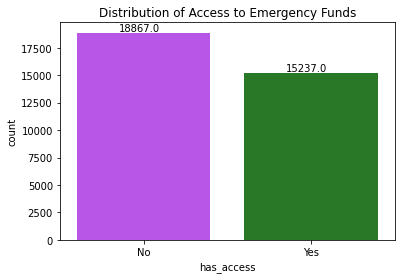

In [58]:
# barplot of access to emergency funds
g = sns.countplot(x = 'has_access', data = df2, palette = yes_no_pal)
for p in g.patches:
   g.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+ .25, p.get_height()+100))
g.set(title = "Distribution of Access to Emergency Funds")

The barchart above displays the overall distribution of access to emergency funds. We can see that over half of individuals represented in the data do not have access. This analysis will help to identify which factors are most associated with lack of access, and thus the results could help to inform potential actions or initiatives to expand access. 

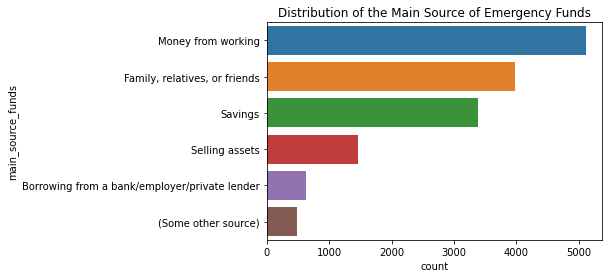

In [59]:
# barplot of main source of emergency funds
chart = sns.countplot(y = 'main_source_funds', 
                      data = df2, 
                      order = ["Money from working","Family, relatives, or friends",
                               "Savings", "Selling assets",
                               "Borrowing from a bank/employer/private lender", "(Some other source)"]).set(
                      title = "Distribution of the Main Source of Emergency Funds")

The barchart above displays the overall distribution of the main source of emergency funds. Most of the individuals with access to emergency funds recieve their funding from work, their family and friends, or their savings.

[Text(0.5, 1.0, 'Distribution of Received Wage Payments')]

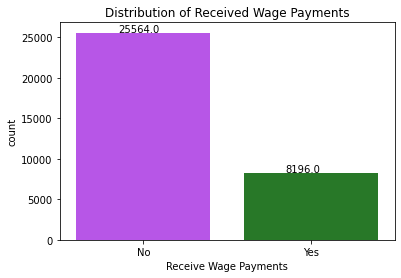

In [60]:
# barplot of recieved wage payments
chart = sns.countplot(x = 'Receive Wage Payments', data = df2, order = ["No", "Yes"], palette = yes_no_pal)
for p in chart.patches:
   chart.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+ .25, p.get_height()+100))
chart.set(title = "Distribution of Received Wage Payments")

Diving further into the "Money from Working" category, we can see that only 8196 individuals recieve wage payments. This analysis suggests that recieving wage payments may be a key factor in determining access to emergency funds.

### Gender: Protected Attribute of Focus

In the data, gender is defined in the binary sense with the two options "Male" and "Female".

[Text(0.5, 1.0, 'Gender Distribution')]

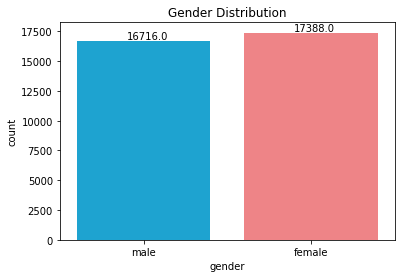

In [61]:
# barplot female versus not
g = sns.countplot(x = 'gender', data = df2, palette = gender_palette)

for p in g.patches:
   g.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+ .3, p.get_height()+100))

g.set(title = "Gender Distribution")

The barplot above displays the gender distribution of our sample. We can see that the number of males versus females is almost evenly split.

[Text(0.5, 1.0, 'Distribution of Access by Gender')]

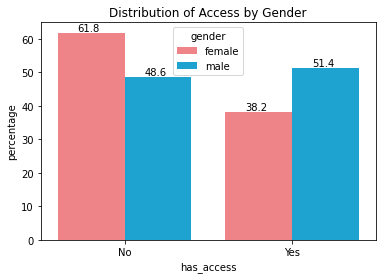

In [62]:
# barplot of possibility of coming up with emergency funds by gender
# 1 = yes have access, 2 = no, 3 = don't know, 4 = refuse
gender_fin_counts = (df2.groupby(['gender'])['has_access']
                     .value_counts(normalize = True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     )

g = sns.barplot(x = "has_access", y = "percentage", hue="gender", data = gender_fin_counts, palette = [red, blue])
for p in g.patches:
   g.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.12, p.get_height()+.5))
g.set(title = "Distribution of Access by Gender")

The bar plot above displays the relationship between gender and access to emergency funds. It is clear that males are more likely to have access than females. This points to the idea that there is likely gender inequity with regard to financial status within the Sub-Saharan region. Furthermore, this imbalance is important to be aware of because it could introduce bias into our model; since there are fewer females than males with access in the data, the model may be less accurate in predicting true positives for females.

In [63]:
#@title 
%%capture --no-display
df_gender = df2[['gender', 'economy']].query("gender == 'female'").groupby('economy').count()
df_gender = df_gender.assign(male = lambda df_gender: 1000 - df_gender['gender']).rename(columns = {'gender': 'female'})

#Percent of females
df_gender = df_gender.assign(Female = lambda df_gender: (df_gender['female'])/10)

#Percent of males
df_gender = df_gender.assign(Male = lambda df_gender: 100 - df_gender['Female'])

df_gender = df_gender[['Male', 'Female']]
df_gender['economy'] = df2.economy.unique()
df_gender = df_gender.sort_values('Male')

# Counting by Access to Emergency Funds by gender
f_access = df2[['has_access', 'economy', 'gender']].query("has_access == 'Yes' & gender == 'female'").groupby('economy').count()
m_access = df2[['has_access', 'economy', 'gender']].query("has_access == 'Yes'& gender != 'female'").groupby('economy').count()

# Defining acccess vs no access by country columms
f_count = f_access['has_access']
m_count = m_access['has_access']

# Merging columns
df3 = pd.merge(f_count, m_count, how='inner', on = 'economy')
df3 = df3.assign(total = lambda df3: df3['has_access_x']+df3['has_access_y'])

#Percent of females with access
df3 = df3.assign(f_percent_access = lambda df3: (df3['has_access_x']/df3["total"])*100)

#Percent of males with access
df3 = df3.assign(m_percent_access = 100 - df3['f_percent_access'])

df3['economy'] = df2.economy.unique()
df3 = df3[['m_percent_access', 'f_percent_access',   'economy']]
df3 = df3.sort_values('m_percent_access')
df3 = df3.rename(columns = {'m_percent_access':'Males With Acesss', 'f_percent_access': 'Females With Access'})

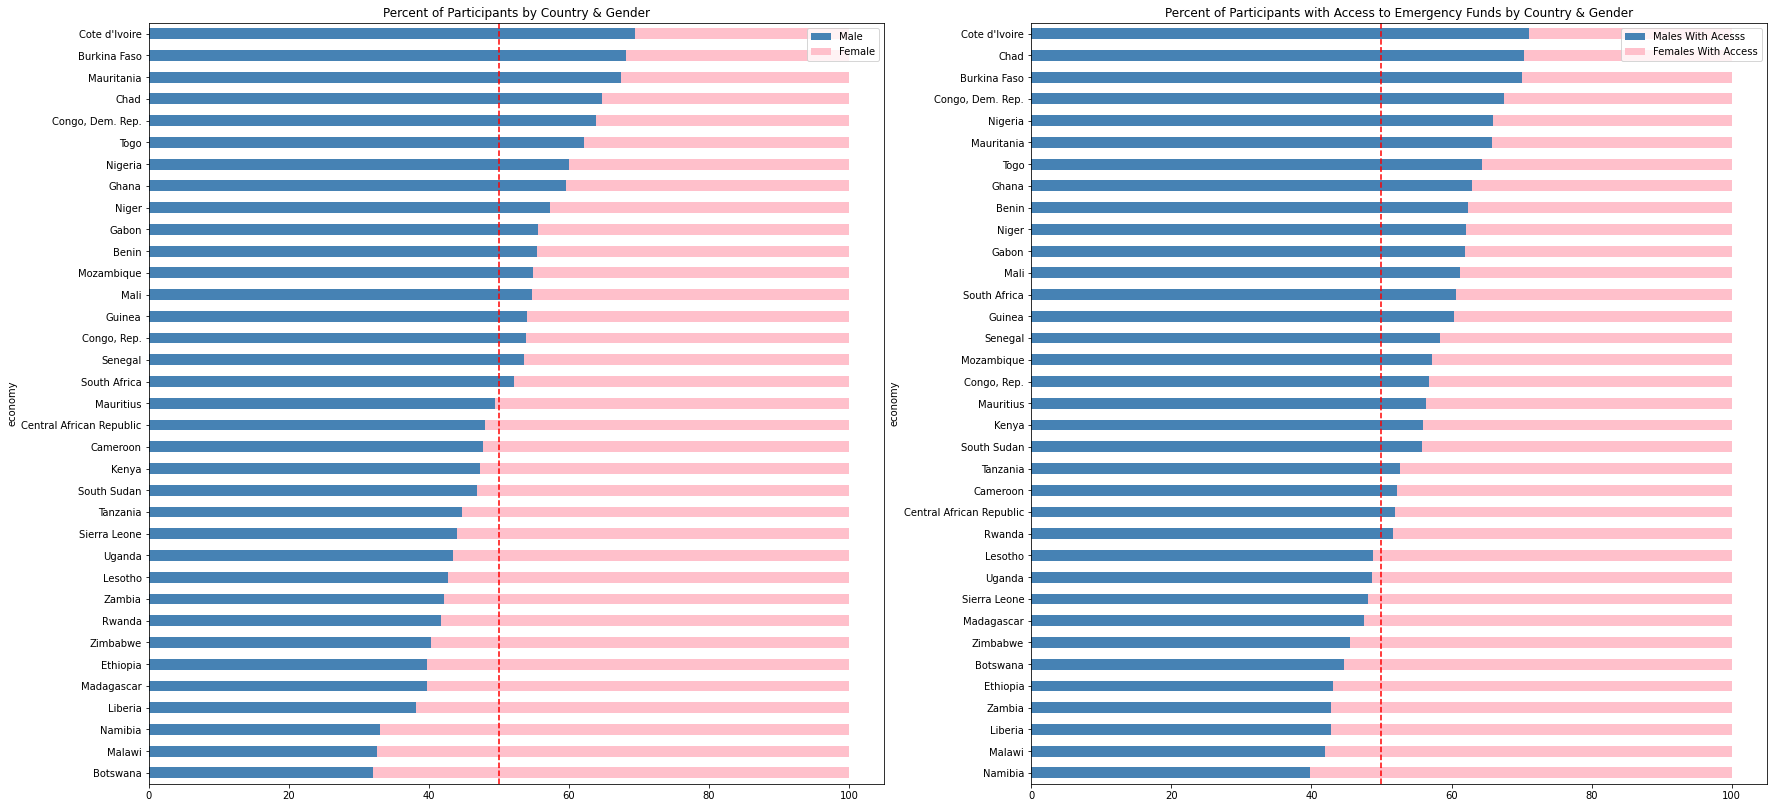

In [64]:
# create new figure
fig = plt.figure()
#add sub plot
ax1 = fig.add_subplot(1,2,1)
# fig 1
df_gender.set_index('economy').plot(kind='barh', stacked=True, color=['steelblue', 'pink'], title = "Percent of Participants by Country & Gender", ax = ax1).axvline(x = 50, color = "red", linestyle = "dashed")
#add sub plot
ax2 = fig.add_subplot(1,2,2)
# fig 2
fig2 = df3.set_index('economy').plot(kind='barh', stacked=True, color=['steelblue', 'pink'], title = "Percent of Participants with Access to Emergency Funds by Country & Gender", ax = ax2).axvline(x = 50, color = "red", linestyle = "dashed")
# set fig size
fig.set_size_inches(29, 14)

A similar trend emerges by country. Although only about 50% of the countries have a higher percentage of men represented in the questionaire, in 75% of the countries more men that have access to emergency funds than women.

### Other Demographic Variables

#### Education Level

Education level is defined as a categorical variable with three categories: "primary" = middle school or less, "secondary" = through high school, "tertiary" = college/university or higher.

[Text(0.5, 1.0, 'Education Count by Gender')]

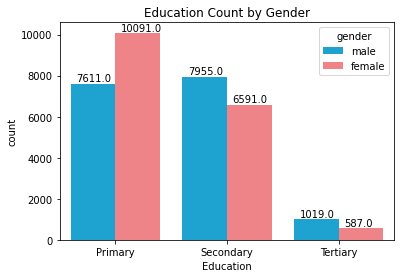

In [65]:
ebg = sns.countplot(x="Education", hue= "gender", palette= gender_palette, order= ['Primary', 'Secondary', 'Tertiary'], data= df2)
for p in ebg.patches:
   ebg.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.05, p.get_height()+100))

ebg.set(title= "Education Count by Gender")


The barplot above shows us that the majority of individuals received at highest a secondary (highschool) education, and a very small portion of individuals have received tertiary (post-secondary) education. Furthermore, we can see that there are more women with primary education, but more men with secondary or tertiary education. Overall we can see that there are more men with higher education than women. About 1,000 more men than women have received a secondary education and there is about double the amount of men with tertiary education compared to women. 

[Text(0.5, 0, 'Education Level'),
 Text(0.5, 1.0, 'Access to Emergency Funds by Education Level')]

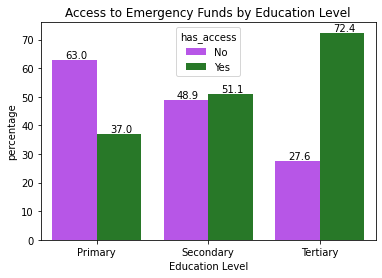

In [66]:
educ_perc = (df2.groupby(['Education'])['has_access']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     )

educ_access = sns.barplot(x = "Education", y = "percentage", order= ['Primary', 'Secondary', 'Tertiary'], hue="has_access", palette= yes_no_pal, hue_order= ['No', 'Yes'], data = educ_perc)
for p in educ_access.patches:
   educ_access.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.12, p.get_height()+.5))
educ_access.set(title = "Access to Emergency Funds by Education Level", xlabel = 'Education Level')

In the barplot above we can see the distribution of funds based on an individual’s highest education level. Despite the very low number of individuals having completed tertiary education, it is clear from the plot above that people who have tertiary education are much more likely to have access to emergency funds than individuals who only have primary or secondary education. 63% of people with only a primary education do not have access to emergency funds compared to 37% of people who do. These numbers are more evenly distributed for those with secondary education, with about 49% of people not having access to emergency funds, while 51% of people do have access. Finally, for those with a tertiary level of education we can see that about 72% of people have access to emergency funds while only 28% of that group does not have access. 
Overall, we can make the assumption that people with a higher level of education are more likely to have access to emergency funds. 


#### Age

Age is defined as a continuous numeric variable indicating age in years rounded to the nearest whole number. 

Text(0.5, 0.98, 'Access to Emergency Funds by Age')

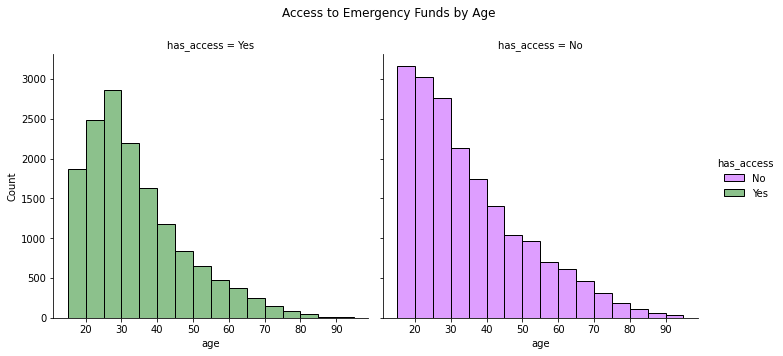

In [67]:
age2 = sns.displot(x= "age", col= "has_access", hue="has_access", bins = [15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95], col_order= ["Yes", "No"], hue_order= ['No', 'Yes'],palette= yes_no_pal, data=df2)

age2.fig.subplots_adjust(top=.85)
age2.fig.suptitle('Access to Emergency Funds by Age')


In the plot above, each bar represents a five-year age range. The first bar measures those aged 15-19, then 20-24, 25-29, and so on, until we reach the last bar that goes from 90-95. Overall we can see that people aged 20-35 have the most access to emergency funds. 

### Financial 

Next, we analyze a few key financial variables in this data set. The three financial variables we will focus on are income quantile, whether or not an individual has a financial account, and employment status. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Income Quantiles')

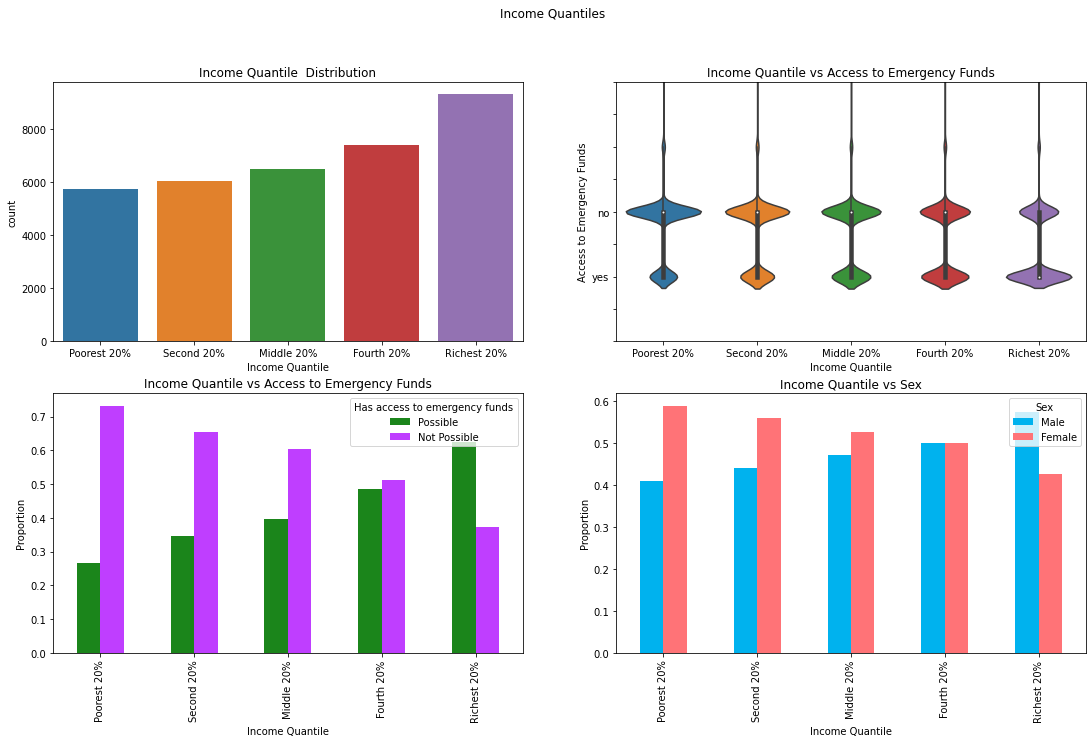

In [68]:
#@title Income Quantile

# cant remember if i used all of these, i will check back later
df_inq = df['inc_q']
df_inq_fin24 = df[['inc_q','fin24']]
df_inq_fin24_wp = df[['inc_q','fin24', 'wpid_random']]
#df_inq_fin24_wp.query('fin24 ==1 and fin24 ==2')
df_inq_fem = df[['inc_q','female']]


df_inq_24wp = df_inq_fin24_wp[(df_inq_fin24_wp['fin24']<=2)]
#stacking plots
# create new figure
fig = plt.figure()
#add sub plot
ax1 = fig.add_subplot(2,2,1) 
#hand off to pandas
sns.countplot(df_inq, ax = ax1)
ax1.set_xlabel("Income Quantile")
ax1.set_xticklabels(['Poorest 20%','Second 20%','Middle 20%','Fourth 20%','Richest 20%'])
ax1.title.set_text('Income Quantile  Distribution')

# second graph
ax2 = fig.add_subplot(2,2,2)
sns.violinplot(data = df, x='inc_q', y='fin24', ax = ax2)
ax2.set_xlabel("Income Quantile")
ax2.set_ylabel("Access to Emergency Funds")
ax2.title.set_text('Income Quantile vs Access to Emergency Funds')
ax2.set_xticklabels(['Poorest 20%','Second 20%','Middle 20%','Fourth 20%','Richest 20%'])
ax2.set_yticklabels(['','','yes','','no','','','',''])
ax2.set(ylim=(0, 4))


## third graph
# set up proportions

# count each group
counts_df = df_inq_24wp.groupby(["fin24","inc_q"])['wpid_random'].count().unstack()
# calculate percents
inc_q_percents_df = counts_df.div(counts_df.sum()).T

ax3 = fig.add_subplot(2,2,3)

inc_q_percents_df.plot(kind = "bar", stacked = False, color = ['#1B851B','#BF3EFF'], ax = ax3)
ax3.legend(["Possible","Not Possible"],
           title = "Has access to emergency funds")

ax3.set_ylabel("Proportion")
ax3.set_xlabel("Income Quantile")
#ax3.set_xticklabels(ax.get_xticklabels(),rotation = 0)
ax3.set_xticklabels(['Poorest 20%','Second 20%','Middle 20%','Fourth 20%','Richest 20%'])
ax3.title.set_text('Income Quantile vs Access to Emergency Funds')


## Fourth graph

# count each group
fem_counts_df = df.groupby(["female","inc_q"])['wpid_random'].count().unstack()
# calculate percents
fem_percents_df = fem_counts_df.div(fem_counts_df.sum()).T


ax4 = fig.add_subplot(2,2,4)

fem_percents_df.plot(kind = "bar", stacked = False, color = ['#00B2EE','#FF7377'], ax = ax4)
ax4.legend(["Male","Female"],
           title = "Sex")

ax4.set_ylabel("Proportion")
ax4.set_xlabel("Income Quantile")
ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90)
ax4.set_xticklabels(['Poorest 20%','Second 20%','Middle 20%','Fourth 20%','Richest 20%'])
ax4.title.set_text('Income Quantile vs Sex')



fig.set_size_inches(18.5, 10.5)
fig.suptitle("Income Quantiles")

Income quantile is separated into 5 quantiles with 1 being the poorest and 5 being the richest. The mean for all included Sub-Sahara countries is 3.241. This means that all the countries average out to be about middle class.

Income quantile 5, the richest 20%, is the largest quantile. Males comprise the majority of this quantile. Women compose the majority of the poorest 20%, second poorest 20%, and middle 20%, which are the poorest quantiles. The highest count of people in the richest 20% have more access to emergency funds while the highest count of people in the lowest 20% dont have access to emergency funds.

#### Has a financial account

This variable is relevant to our analysis because if an individual does not have a financial account, they likely do not have a large amount of extra funds to store.

[Text(0.5, 0, 'Has a financial account?'),
 Text(0.5, 1.0, 'Distribution of Has a Financial Account')]

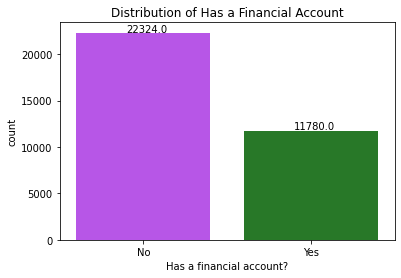

In [69]:
# barplot of number of people who have a bank account
g = sns.countplot(x = 'account_fin', data = df2, palette = yes_no_pal)
for p in g.patches:
   g.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+ .3, p.get_height()+100))
g.set(title = "Distribution of Has a Financial Account", xlabel = 'Has a financial account?')

The barplot above displays the distribution of how many individuals in our sample have a financial account versus do not have a financial account. We can see that about two thirds of individuals do not have an account. This is likely connected to the lack of access to emergency funds displayed above given that if an individual does not have a financial account, we would expect they are less likely to have a source of emergency funds, as emergency funds are generally stored in an account.  

In [70]:
%%capture --no-display
# reasons for no financial account
# pivot data to long format
df_long = df[['fin11a', "fin11b", "fin11c", "fin11d", "fin11e", "fin11f", "fin11g", "fin11h"]]\
.stack()\
.reset_index()
df_long.rename(columns = {'level_1':'reason', 0:'value'}, inplace = True)
df3 = df_long.query('value == 1.0') # filter to only "yes" answers for each reason
# recode reason values
df3.loc[df3['reason'] == 'fin11a', "reason"] = 'distance'
df3.loc[df3['reason'] == 'fin11b', "reason"] = 'expense'
df3.loc[df3['reason'] == 'fin11c', "reason"] = 'no_documentation'
df3.loc[df3['reason'] == 'fin11d', "reason"] = 'lack_trust'
df3.loc[df3['reason'] == 'fin11e', "reason"] = 'religious'
df3.loc[df3['reason'] == 'fin11f', "reason"] = 'lack_money'
df3.loc[df3['reason'] == 'fin11g', "reason"] = 'family_member_has'
df3.loc[df3['reason'] == 'fin11h', "reason"] = 'no_need'
df3.head()

# aggregate counts by reason
reason_counts = df3.groupby('reason').agg('count').reset_index()

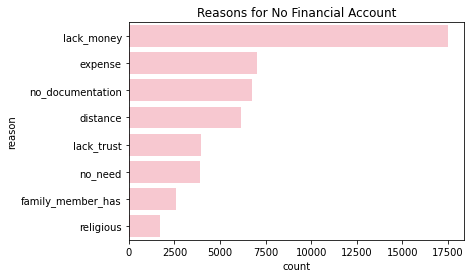

In [71]:
# barplot of count by reason-- seaborn
reasons_plot = sns.barplot(y = 'reason',
                           x = 'value', 
                           data = reason_counts, 
                           palette = [pink, pink, pink, pink, pink, pink, pink, pink],
                      order = ["lack_money","expense",
                               "no_documentation", "distance",
                               "lack_trust", "no_need",
                               "family_member_has", "religious"]).set(
                      title = "Reasons for No Financial Account",
                      xlabel = "count")

The bar plot above displays the distribution of reasons for not having a financial account for those who answered "No" to the question of whether or not they have a financial account. We can see that the top reason by far is that folks simply do not have money to keep in an account, and the second to top reason is the expense of of the account itself. This points to the idea that a large percentage of the folks sampled are very poor, and thus have neither a financial account nor emergency funds.

[Text(0.5, 0, 'Has a financial account?'),
 Text(0.5, 1.0, 'Distribution of Has a Financial Account by Gender')]

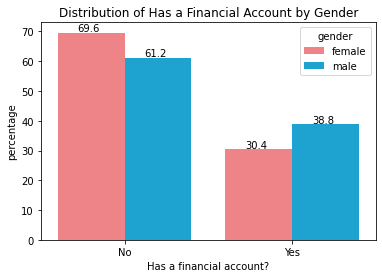

In [72]:
gender_acc_counts = (df2.groupby(['gender'])['account_fin']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     )

g = sns.barplot(x = "account_fin", y = "percentage", hue="gender", data = gender_acc_counts, palette = [red, blue])
for p in g.patches:
   g.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.12, p.get_height()+.5))
g.set(title = "Distribution of Has a Financial Account by Gender", xlabel = 'Has a financial account?')

The bar chart above displays the relationship between gender and whether or not an individual has a financial account. We can see that males are more likely to have a financial account than females. Thus further reinforces the idea that there is gender inequity with regard to financial status.

#### Employment Status

Employment status is relevant to our analysis because work is generally a person's main source of income which would allow them to have money saved for emergencies.

[Text(0.5, 0, 'In workforce?'),
 Text(0.5, 1.0, 'Distribution of Whether or not in Workforce')]

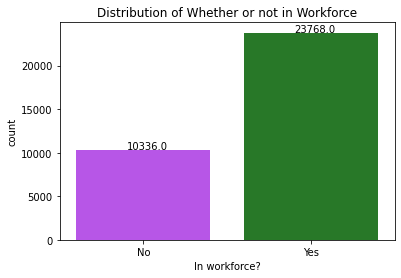

In [73]:
# Distribution by in workforce
g = sns.countplot(x = 'emp_in', data = df2, palette = yes_no_pal)
for p in g.patches:
   g.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+ .3, p.get_height()+100))
g.set(title = "Distribution of Whether or not in Workforce", xlabel = "In workforce?")

It appears that about three-fourths of individuals are in the workforce, which is much higher than the percentage of individuals who have access to emergency funds. This may indicate that many people who have jobs do not get paid enough to have emergency funds in savings.

[Text(0.5, 0, 'In workforce?'),
 Text(0.5, 1.0, 'Distribution of In Workforce by Gender')]

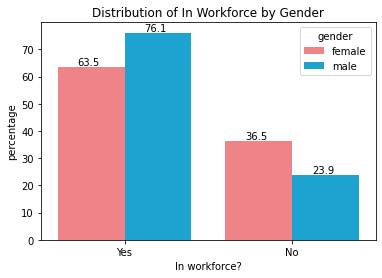

In [74]:
# Distribution by Gender and In Workforce
gender_emp_counts = (df2.groupby(['gender'])['emp_in']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
)

g = sns.barplot(x = "emp_in", y = "percentage", hue="gender", data = gender_emp_counts, palette = [red, blue])
for p in g.patches:
   g.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.12, p.get_height()+.5))
g.set(title = "Distribution of In Workforce by Gender", xlabel = "In workforce?")

The bar plot above displays the relationship between gender and employment status. It is clear that more females than males are unemployed. This may be one factor contributing to the gender inequity with regard to financial status displayed in the above plots.

# Pre-processing

In this section, we will perform data cleaning so that the data that we input into the model is in a format such that it can be appropriately interpreted by the machine learning model.

In [75]:
# change name of gender variable to be more interpretable
df = df.rename(columns = {'female': 'gender'})

First, we removed the arbitrary variables 'economycode' and 'regionwb'-- 'economycode' is essentially a duplicate of 'economy', and 'regionwb' is the same for all rows since this is the variable that we filtered by.

In [76]:
# remove arbitrary variables
col = list(df.columns)
col.remove("economycode")
col.remove("regionwb")
df = df[col]

Next, we checked for variables with a high percentage of missing values. Several variables have many missing values because they are follow-up questions to a previous question that are only asked if the respondent gives a specific for a previous question.

In [77]:
# check for missing values
# code from: https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d
drop_list = list()
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if pct_missing >= 0.30: drop_list.append(col)
    print('{} - {}%'.format(col, round(pct_missing*100)))

economy - 0%
pop_adult - 0%
wpid_random - 0%
wgt - 0%
gender - 0%
age - 1%
educ - 0%
inc_q - 0%
emp_in - 0%
fin2 - 0%
fin3 - 81%
fin4 - 82%
fin5 - 70%
fin6 - 70%
fin7 - 0%
fin8 - 95%
fin9 - 69%
fin10 - 69%
fin11a - 31%
fin11b - 31%
fin11c - 31%
fin11d - 31%
fin11e - 31%
fin11f - 31%
fin11g - 31%
fin11h - 31%
fin14a - 0%
fin14b - 0%
fin14c - 96%
fin15 - 0%
fin16 - 0%
fin17a - 0%
fin17b - 3%
fin19 - 0%
fin20 - 0%
fin21 - 0%
fin22a - 0%
fin22b - 0%
fin22c - 76%
fin24 - 0%
fin25 - 56%
fin26 - 3%
fin27a - 69%
fin27b - 69%
fin27c1 - 92%
fin27c2 - 92%
fin28 - 3%
fin29a - 66%
fin29b - 66%
fin29c1 - 90%
fin29c2 - 90%
fin30 - 0%
fin31a - 71%
fin31b - 71%
fin31c - 81%
fin32 - 0%
fin33 - 76%
fin34a - 76%
fin34b - 76%
fin34c1 - 88%
fin34c2 - 88%
fin35 - 89%
fin36 - 95%
fin37 - 0%
fin38 - 0%
fin39a - 89%
fin39b - 89%
fin39c1 - 94%
fin39c2 - 94%
fin40 - 99%
fin41 - 100%
fin42 - 3%
fin43a - 75%
fin43b - 75%
fin43c1 - 80%
fin43c2 - 80%
fin44 - 95%
fin45 - 98%
fin46 - 43%
fin47a - 89%
fin47b - 89%
fin47

We chose to drop all variables with more than 30% missing values because we observed by running the model multiple times that variables with NA percentages above this threshold had no impact on the model accuracy or fairness. Thus, it made sense to remove them if their presence is negligible when included in the model.

In [78]:
%%capture --no-display
# drop features with more than 30% missing values
df.drop(drop_list, axis=1, inplace=True)

Next, we checked for variables with high levels of redundancy (i.e. little variation).

In [79]:
# check for repetitive features
# code from: https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d
num_rows = len(df.index)
low_information_cols = [] #

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

pay_onlne: 95.84571%
0.0    33546
NaN     1000
1.0      454
Name: pay_onlne, dtype: int64



pay_online is the only feature with more than 95% of the values being the same. We will remove it because after previously running the model including it, we saw that it had very little impact on the model. 

In [80]:
# drop pay_online
df.drop(low_information_cols, axis=1, inplace=True)

Next, we replaced all 'don't know' and 'refuse' responses (coded as 3 and 4 respectively) with NAs.

In [81]:
# separate df into two dataframes so we can replace 3s and 4s with NAs for relevant variables
dont_remove = ['economy', 'pop_adult', 'wgt', 'age', 'educ', 'inc_q', 'remittances']
df2 = df.copy()
df2.drop(dont_remove, axis=1, inplace=True)
df3 = df[dont_remove]

In [82]:
df2.head()

,wpid_random,gender,emp_in,fin2,fin7,fin14a,fin14b,fin15,fin16,fin17a,...,account_mob,account,saved,borrowed,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,pay_cash
12138,143101339,1,0.0,2,2,2,2,2,2,2,...,0.0,0,0,0,4,4,4,4.0,4,0.0
12139,123998301,1,1.0,2,2,2,2,2,2,2,...,0.0,1,0,1,4,4,4,4.0,3,0.0
12140,157155643,1,1.0,2,2,1,1,2,2,2,...,0.0,0,0,0,4,4,4,4.0,4,0.0
12141,155618899,2,1.0,2,2,2,2,1,2,2,...,0.0,0,1,1,4,4,4,4.0,3,0.0
12142,143861320,1,1.0,2,2,2,2,2,2,2,...,0.0,0,0,0,4,4,4,4.0,4,0.0


In [83]:
df3.head()

,economy,pop_adult,wgt,age,educ,inc_q,remittances
12138,Benin,6211794.0,1.909609,60.0,1.0,1,5.0
12139,Benin,6211794.0,2.075761,45.0,1.0,1,1.0
12140,Benin,6211794.0,0.785666,27.0,3.0,4,2.0
12141,Benin,6211794.0,1.450568,24.0,1.0,2,5.0
12142,Benin,6211794.0,0.461588,22.0,1.0,5,5.0


We then replaced all remaining missing values (including missing values not removed previously and 'don't know' and 'refuse' values) with the column mean rounded to the nearest whole number (i.e. the most frequent value if the variable is categorical).

In [84]:
# replace don't know and refuse values with na
df2 = df2.replace(3,np.nan)
df2 = df2.replace(4,np.nan)
# recode so that 0 = No, 1 = Yes
df2 = df2.replace(2, 0)
frames = [df2, df3]
# combine separate parts back into one
df_replaced = pd.concat(frames, axis=1)
# df_replaced.dropna(axis=0,inplace=True)
# len(df_replaced)

In [85]:
# replace NAs with rounded column means-- not sure if this is the best approach
column_means = df_replaced.mean()
df_replaced = df_replaced.fillna(np.around(column_means, 0))

<ipython-input-85-25690068320b>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  column_means = df_replaced.mean()


Next, we temporarily removed the economy variable because it is our only string variable and we will need to recode it in order to put it in the model.

Then, we converted all float values to ints because we do not have any variables with non-whole number values, and it is simpler to have everything as ints.

In [86]:
# convert all floats to ints
cols = list(df_replaced.columns)
cols.remove('economy')
df_replaced1 = df_replaced.copy()
df_replaced1 = df_replaced1[cols].astype(int)
df_replaced2 = df_replaced['economy']
frames = [df_replaced1, df_replaced2]
df_replaced = pd.concat(frames, axis=1)

In [87]:
df_replaced.head()

,wpid_random,gender,emp_in,fin2,fin7,fin14a,fin14b,fin15,fin16,fin17a,...,receive_agriculture,pay_utilities,pay_cash,pop_adult,wgt,age,educ,inc_q,remittances,economy
12138,143101339,1,0,0,0,0,0,0,0,0,...,0,1,0,6211794,1,60,1,1,5,Benin
12139,123998301,1,1,0,0,0,0,0,0,0,...,0,1,0,6211794,2,45,1,1,1,Benin
12140,157155643,1,1,0,0,1,1,0,0,0,...,0,1,0,6211794,0,27,3,4,2,Benin
12141,155618899,0,1,0,0,0,0,1,0,0,...,0,1,0,6211794,1,24,1,2,5,Benin
12142,143861320,1,1,0,0,0,0,0,0,0,...,0,1,0,6211794,0,22,1,5,5,Benin


Finally, we will convert the 'economy' variable into a binary variable called 'high_access_country', which will have a value of 1 if the percentage of sampled individuals from the country who have access to emergency funds (fin24 = 1) is greater than or equal to 50% and a value of 0 if the percentage is less than 50%.

In [88]:
# Recode fin24 values
df.loc[df['fin24'] == 1, "fin24"] = 'Yes'
df.loc[df['fin24'] == 2, "fin24"] = 'No'
df.loc[df['fin24'] == 3, "fin24"] = 'Don\'t Know'
df.loc[df['fin24'] == 4, "fin24"] = 'Refuse'

# Counting by Access to Emergency Funds by country
access = df[['fin24', 'economy']].query("fin24 == 'Yes'").groupby('economy').count()
no_access = df[['fin24', 'economy']].query("fin24 != 'Yes'").groupby('economy').count()
access = access.rename(columns = {'fin24': 'access'})
no_access = no_access.rename(columns = {'fin24': 'no_access'})

# Defining acccess vs no access by country columms
a_count = access['access']
no_a_count = no_access['no_access']

# Merging columns
df3 = pd.merge(a_count, no_a_count, how='inner', on = 'economy').assign(total = lambda df3: df3['access']+df3['no_access'])
df3 = df3.assign(percent_access = lambda df3: df3['access']/df3['total']*100)

conditions = [
    (df3["percent_access"].lt(20)),
    (df3["percent_access"].ge(20) & df3["percent_access"].lt(40)),
    (df3["percent_access"].ge(40) & df3["percent_access"].lt(60)),
    (df3["percent_access"].ge(60) & df3["percent_access"].lt(80)),
    (df3["percent_access"].ge(80)),
]

# Least Access = 1 and Most Access = 5
choices = [1, 2, 3, 4, 5]

df3["access_cat"] = np.select(conditions, choices)
df3 = df3["access_cat"]
df_replaced = df_replaced.set_index('economy')

df_replaced = df_replaced.join(df3, how = 'left', lsuffix='left', rsuffix='right')
df_replaced = df_replaced.reset_index().drop(columns = ['economy'])
df_replaced 

,wpid_random,gender,emp_in,fin2,fin7,fin14a,fin14b,fin15,fin16,fin17a,...,receive_agriculture,pay_utilities,pay_cash,pop_adult,wgt,age,educ,inc_q,remittances,access_cat
0,143101339,1,0,0,0,0,0,0,0,0,...,0,1,0,6211794,1,60,1,1,5,3
1,123998301,1,1,0,0,0,0,0,0,0,...,0,1,0,6211794,2,45,1,1,1,3
2,157155643,1,1,0,0,1,1,0,0,0,...,0,1,0,6211794,0,27,3,4,2,3
3,155618899,0,1,0,0,0,0,1,0,0,...,0,1,0,6211794,1,24,1,2,5,3
4,143861320,1,1,0,0,0,0,0,0,0,...,0,1,0,6211794,0,22,1,5,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,167986916,0,0,0,0,0,0,0,0,0,...,0,1,0,9467437,0,56,1,3,5,3
34996,121992603,1,1,1,0,0,0,1,0,0,...,0,1,0,9467437,0,56,1,4,2,3
34997,137769624,1,0,1,0,0,0,1,0,0,...,0,1,0,9467437,1,36,2,4,1,3
34998,181215643,1,1,1,1,1,0,1,0,0,...,0,1,0,9467437,0,35,3,5,1,3


In [89]:
# check that unique values are correct
pd.unique(df_replaced['access_cat'])

array([3, 2, 4, 1])

Created Cartesian product of account & saved to increase accuracy

In [90]:
# make Cartesian product for account & saved

account = pd.unique(df_replaced['account'])
saved = pd.unique(df_replaced['saved'])
cart = []

cart.append(account)
cart.append(saved)

for element in itt.product(*cart):
  print(element)

conditions = [
    (df_replaced["account"].lt(1) & df_replaced["saved"].lt(1)),
    (df_replaced["account"].lt(1) & df_replaced["saved"].le(1)),
    (df_replaced["account"].le(1) & df_replaced["saved"].lt(1)),
    (df_replaced["account"].le(1) & df_replaced["saved"].le(1)),
]

# noaccount_nosaved_= 1, noaccount_saved_= 2, account_nosaved_= 3, account_saved_= 4
choices = ["1", "2", "3", "4"]

df_replaced["account_saved"] = np.select(conditions, choices)
df_replaced = df_replaced.drop(columns = ['account', 'saved'])
df_replaced.head()

(0, 0)
(0, 1)
(1, 0)
(1, 1)


,wpid_random,gender,emp_in,fin2,fin7,fin14a,fin14b,fin15,fin16,fin17a,...,pay_utilities,pay_cash,pop_adult,wgt,age,educ,inc_q,remittances,access_cat,account_saved
0,143101339,1,0,0,0,0,0,0,0,0,...,1,0,6211794,1,60,1,1,5,3,1
1,123998301,1,1,0,0,0,0,0,0,0,...,1,0,6211794,2,45,1,1,1,3,3
2,157155643,1,1,0,0,1,1,0,0,0,...,1,0,6211794,0,27,3,4,2,3,1
3,155618899,0,1,0,0,0,0,1,0,0,...,1,0,6211794,1,24,1,2,5,3,2
4,143861320,1,1,0,0,0,0,0,0,0,...,1,0,6211794,0,22,1,5,5,3,1


In [91]:
df_replaced = df_replaced.rename(columns = {'fin26': 'sent_remittances'})
df_replaced.columns.values.tolist()

['wpid_random',
 'gender',
 'emp_in',
 'fin2',
 'fin7',
 'fin14a',
 'fin14b',
 'fin15',
 'fin16',
 'fin17a',
 'fin17b',
 'fin19',
 'fin20',
 'fin21',
 'fin22a',
 'fin22b',
 'fin24',
 'sent_remittances',
 'fin28',
 'fin30',
 'fin32',
 'fin37',
 'fin38',
 'fin42',
 'mobileowner',
 'fin48',
 'account_fin',
 'account_mob',
 'borrowed',
 'receive_wages',
 'receive_transfers',
 'receive_pension',
 'receive_agriculture',
 'pay_utilities',
 'pay_cash',
 'pop_adult',
 'wgt',
 'age',
 'educ',
 'inc_q',
 'remittances',
 'access_cat',
 'account_saved']

## Split into Train and Test

Before we can split the data into training and testing sets, we must first separate the data into the predictor variables (X) and the outcome variable (y). In this case, y indicates whether or not it would be possible for the individual to come up with emergency funds. The name of this variable in the dataset is fin24, and the values are coded as 0 = not possible, 1 = possible.

This *standardize_dataset* function specifies the protected attribute we are focusing on and structures X (set of predictor variables) and y (outcome variable) such that we can assess the fairness of the predictions for y based on the protected attribute.

In this case, our protected attribute is gender. The gender variable is named *gender* in our dataset, and the values are coded as 0 = female, 1 = male. The variable does not acknowledge other genders outside of the binary male-female.

In [92]:
# define gender as protected attribute
X, y = standardize_dataset(df_replaced, prot_attr=['gender'],
                               target='fin24', usecols=None,
                               dropcols=None, numeric_only=False,
                               dropna=True)

In [93]:
X.head()

,wpid_random,gender,emp_in,fin2,fin7,fin14a,fin14b,fin15,fin16,fin17a,...,pay_utilities,pay_cash,pop_adult,wgt,age,educ,inc_q,remittances,access_cat,account_saved
gender,,,,,,,,,,,,,,,,,,,,,
1,143101339,1,0,0,0,0,0,0,0,0,...,1,0,6211794,1,60,1,1,5,3,1
1,123998301,1,1,0,0,0,0,0,0,0,...,1,0,6211794,2,45,1,1,1,3,3
1,157155643,1,1,0,0,1,1,0,0,0,...,1,0,6211794,0,27,3,4,2,3,1
0,155618899,0,1,0,0,0,0,1,0,0,...,1,0,6211794,1,24,1,2,5,3,2
1,143861320,1,1,0,0,0,0,0,0,0,...,1,0,6211794,0,22,1,5,5,3,1


In [94]:
y.head()

gender
1    0
1    1
1    1
0    1
1    0
Name: fin24, dtype: int64

Here, we split the data into training and testing sets such that the training set is used to "teach" the model, and the testing set is used to test the accuracy. We chose to designate 70% of the data to training and 30% to testing because this is generally the standard train-test ratio in machine learning.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1234567)

# Baseline Model-- Decision Tree

Next, we define and fit our baseline model. We chose a decision tree classifier model because we are predicting a binary outcome (access or no access) and the majority of our predictor variables are also binary variables. We chose this model over a logistic regression model because the accuracy was much higher (68% accuracy for baseline decision tree model versus 55% accuracy for logistic regression model.)

#### Using cross validation to specify max depth

The below code runs an algorithm to determine at which depth to "cut off" the decision tree in order to maximize the accuracy. Since there are so many variables in our data, the original tree without cutting off the max depth is very large and complex. Since many of the variables are not very related to the outcome variable, including all of them adds noise to the model. When we specify the max depth to be 6 based on the graph generated below, the model accuracy improves from 62% to 68%.  

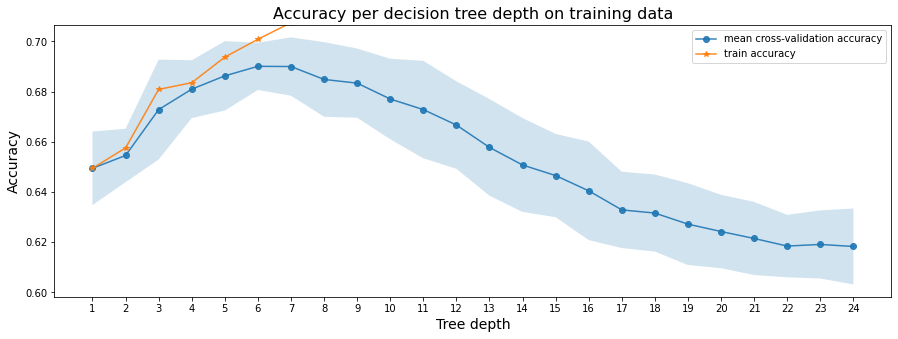

In [96]:
from sklearn.model_selection import cross_val_score
# code sourced from https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [97]:
clf2 = DecisionTreeClassifier(max_depth=6)
# Train Decision Tree Classifer
clf2 = clf2.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf2.predict(X_test)
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
acc_base = accuracy_score(y_test, y_pred)
print(f'[Baseline] The test accuracy of the algorithm is: {acc_base: .2%}')

[Baseline] The test accuracy of the algorithm is:  68.43%


The decision tree model predicts outcomes by organizing the variables into a tree that branches off at each decision point based on the value of the variable at that point. The most influential variables are at the top, and the outcome variable is at the end of each branch. A visualization of the model is displayed below.

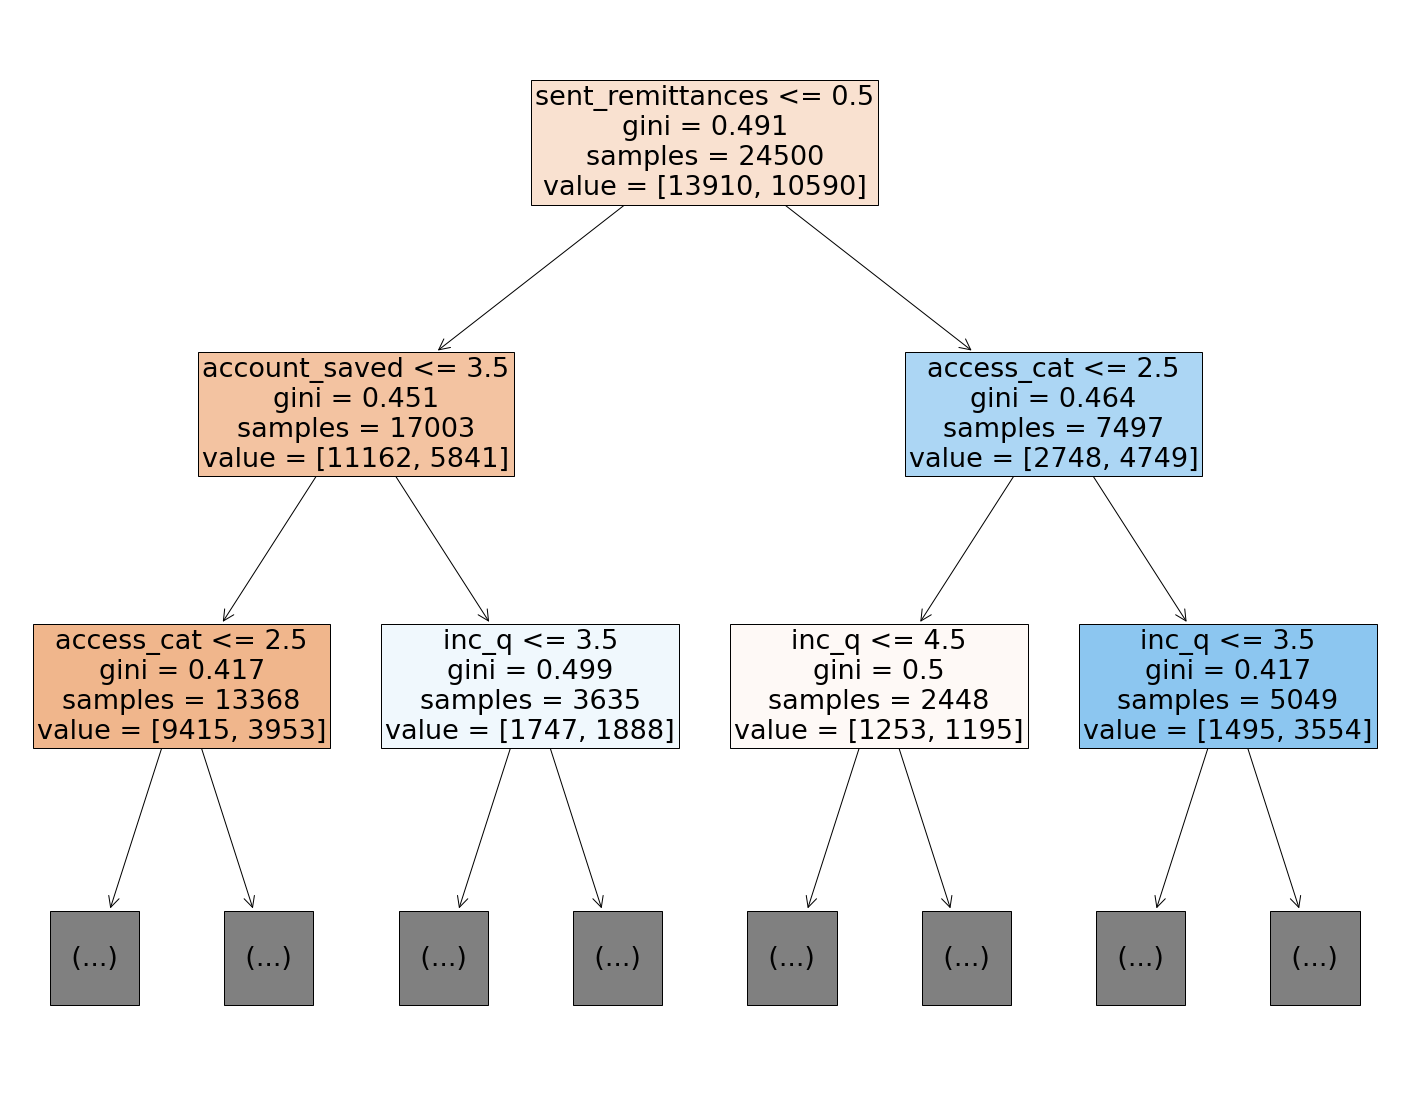

In [98]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf2, 
                   feature_names=X_train.columns,
                   max_depth = 2,
                   filled=True,
                   fontsize = 27)

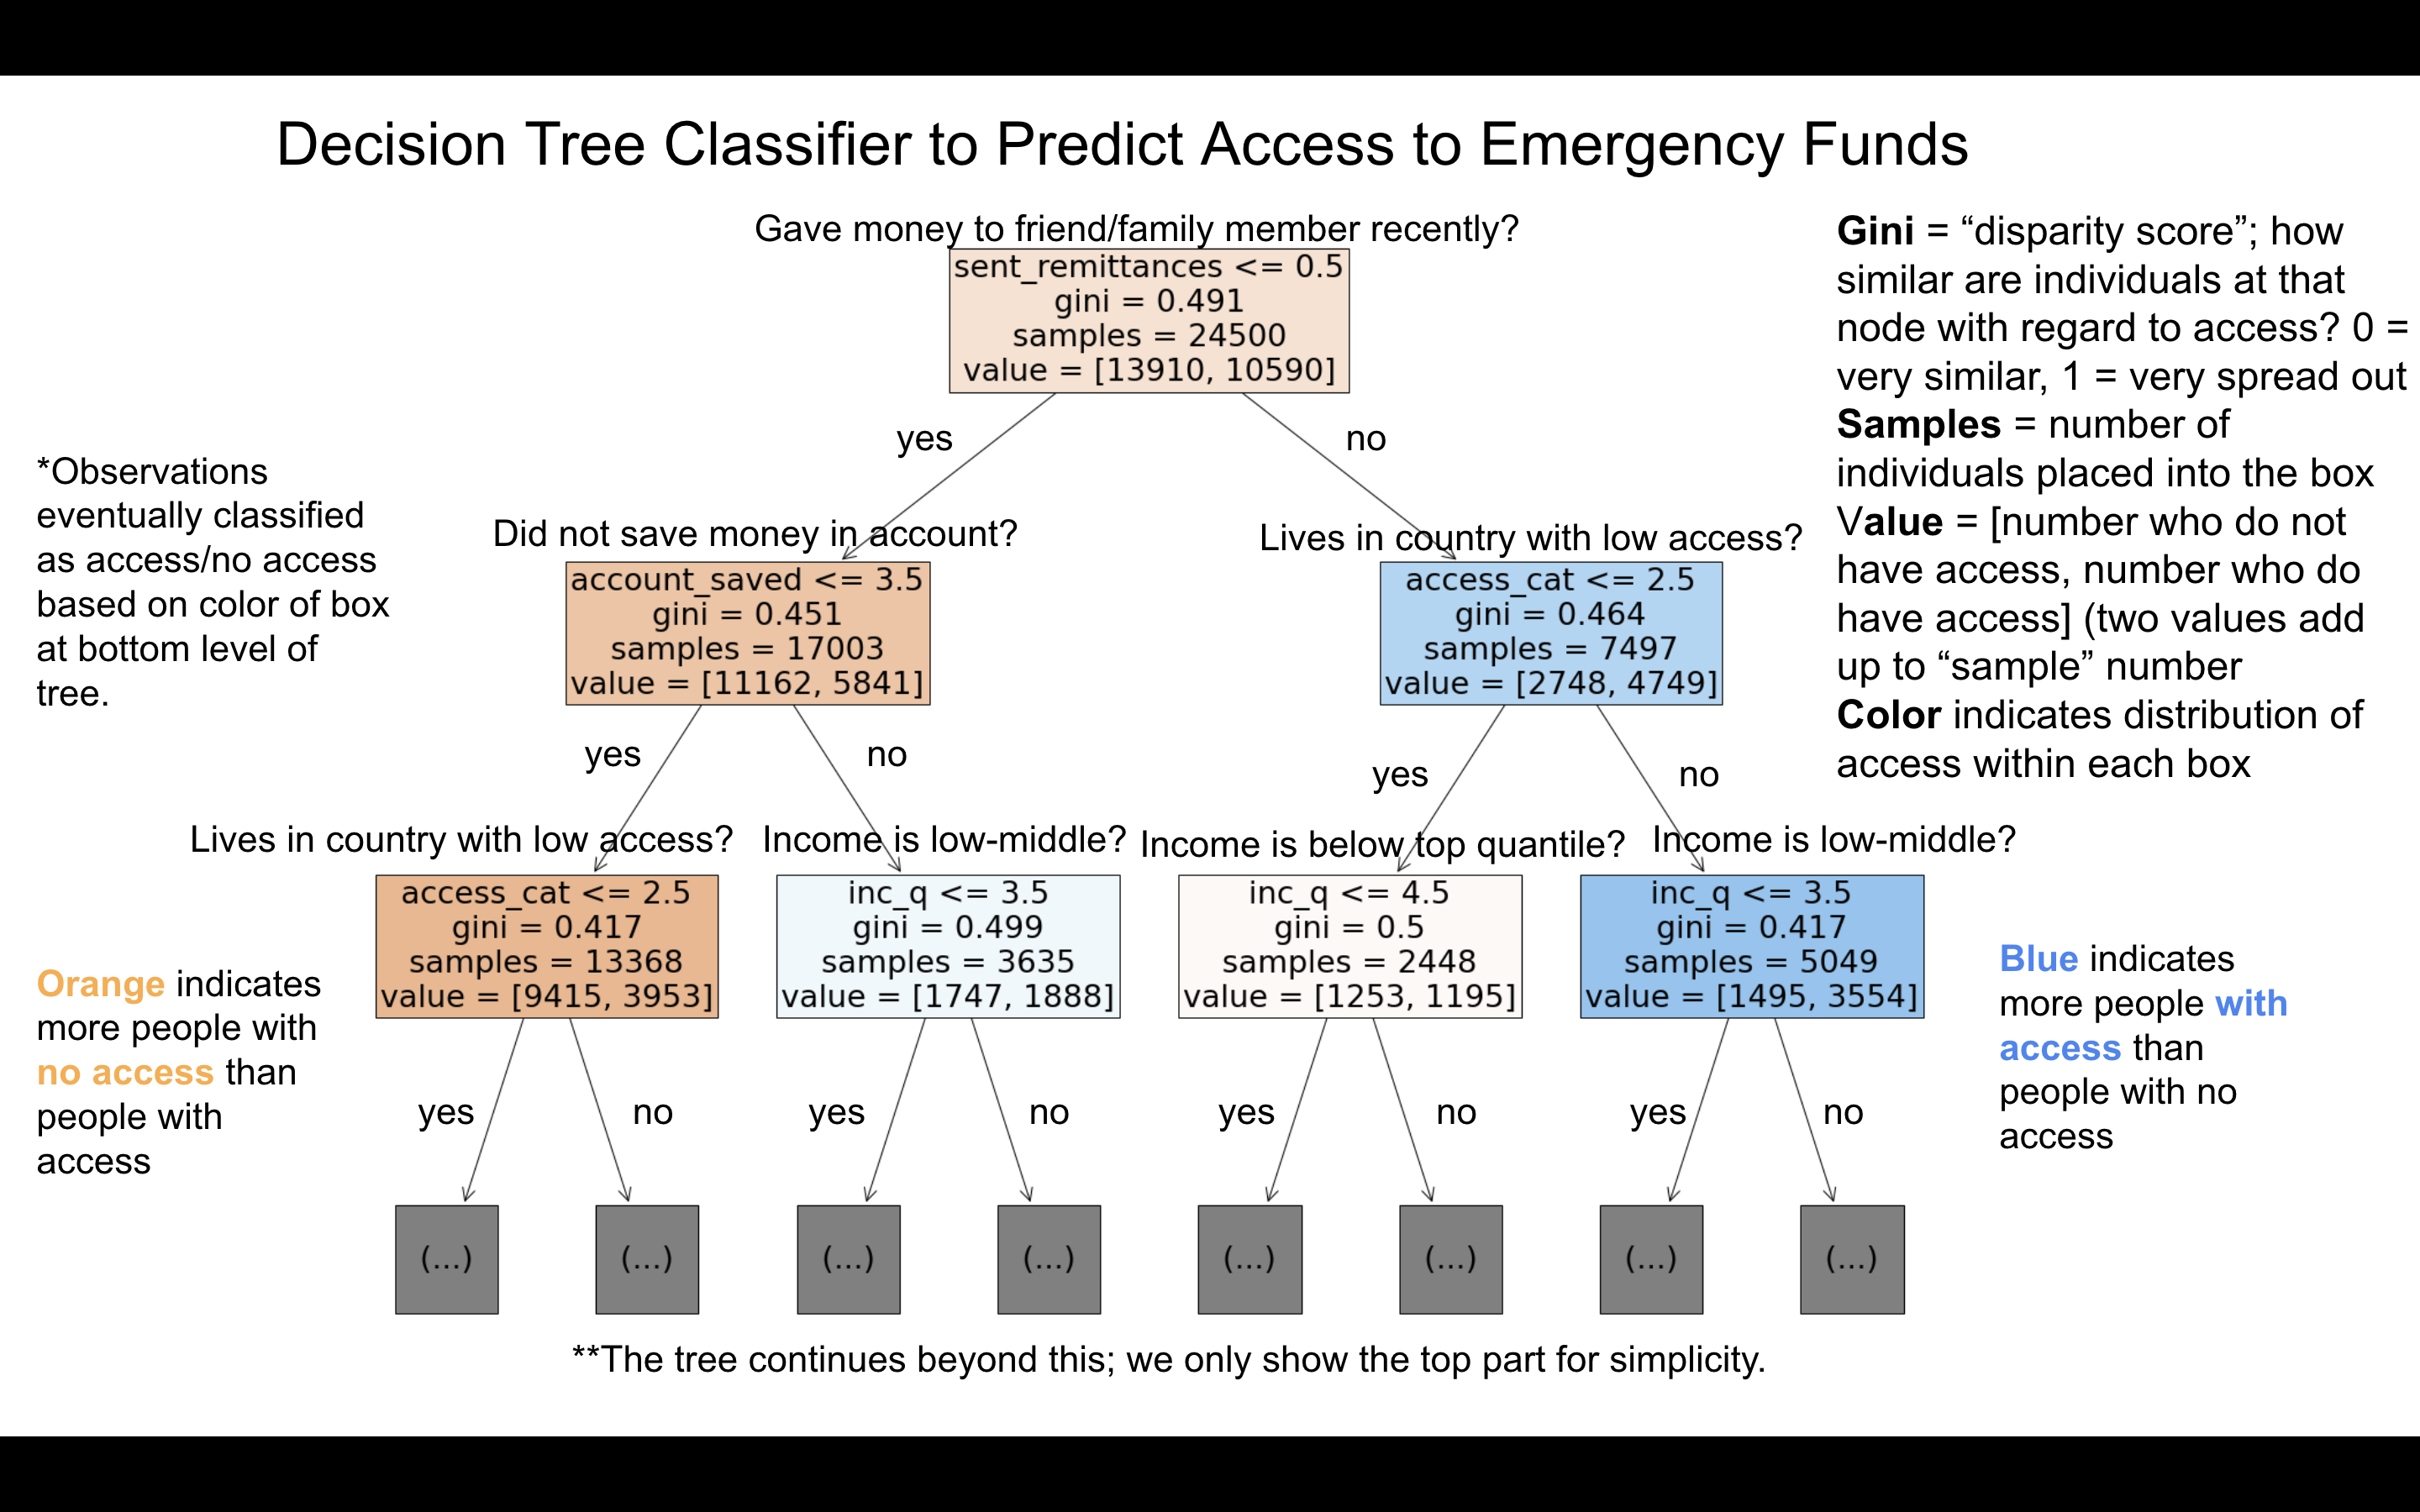

# Metrics

In this section, we explore various metrics to determine how well our model is performing with regard to various measures.

Confusion Matrix

A confusion matrix provides a summary of the accuracy of the model in terms of accurately predicted values as well as error rates.

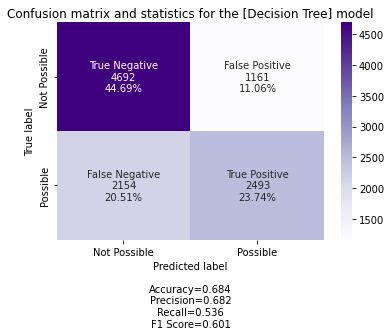

In [99]:
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, "[Decision Tree]")

The confusion matrix shows that our model is more inclined to predicting negatives (no access to emergency funds) than positives. This may be because our data is slightly imbalanced toward negative outcomes.

### Metrics by Gender

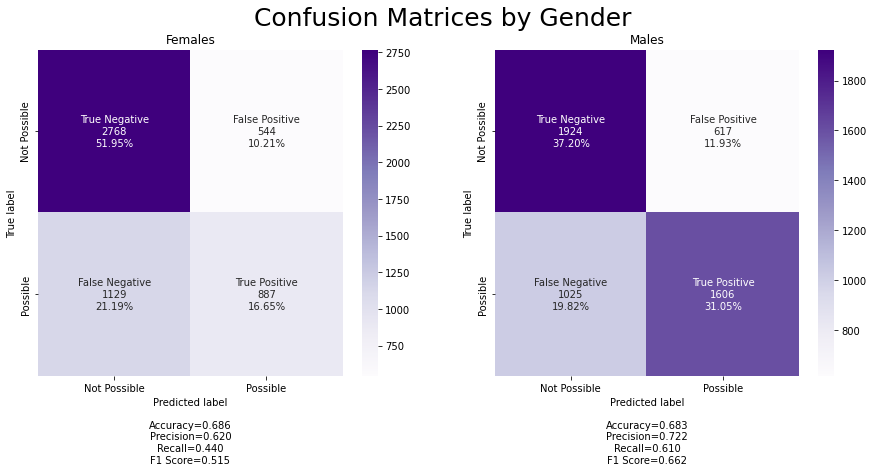

In [100]:
#@title Compare Confusion Matrices by Gender
# create new figure
fig = plt.figure()
#add sub plot
ax1 = fig.add_subplot(1,2,1)
# fig 1
# y true per group
y_test_male = y_test.loc[y_test.index.get_level_values(0) == 1]
y_test_female = y_test.loc[y_test.index.get_level_values(0) == 0]

# y_pred per group
y_pred_male = y_pred[y_test.index.get_level_values(0) == 1]
y_pred_female = y_pred[y_test.index.get_level_values(0) == 0]

# confusion matrix for females only
cf_matrix_f = confusion_matrix(y_test_female, y_pred_female)
make_confusion_matrix(cf_matrix_f, "[Decision Tree]",ax = ax1)
ax1.title.set_text('Females')
#fig1 = cf_matrix_f
#add sub plot
ax2 = fig.add_subplot(1,2,2)
# fig 2
# confusion matrix for males only
cf_matrix_m = confusion_matrix(y_test_male, y_pred_male)
make_confusion_matrix(cf_matrix_m, "[Decision Tree]",ax = ax2)
ax2.title.set_text('Males')
#fig2 = cf_matrix_m
# set fig size
fig.suptitle("Confusion Matrices by Gender",fontsize=25)
fig.set_size_inches(15, 6)



When we create two separate confusion matrices separated by gender, we can see that the model is fairly good at predicting true negatives for both groups, but is significantly better at predicting true positives for males as compared to females. The false positive and false negative error rates are also slightly higher for females as compared to males, yet the rates are pretty similar for both models. 

This may be an example of the model reinforcing biases that are present in the data because we saw from our exploratory data analysis that many fewer females than males have access to emergency funds, so if there are not many females that have true positive values recorded in the data, the model is likely to be less accurate in predicting positive outcomes for females. This could have discriminatory impacts in the case that this model is (hypothetically) used to determine whether or not to provide an individual with a loan based on whether or not they have access to emergency funds (i.e., if they do have access, they are likely to pay back the loan, so they will get the loan, and if they do not have access, they will not get the loan). If very few females in the training data have access, and the model is thus less likely to predict a positive outcome for females as we see here, this will result in fewer females receiving loans. This will result in a self-reinforcing cycle of continued discrimination because if the model continues to predict that females should not get loans, fewer females will get loans, which means fewer females would have the opportunity to pay back loans, and so on.

On the flip side, if the results of the model are (hypothetically) being used to offer support to individuals who are in financial hardship and do not have access to emergency funds, the accuracy in predicting negative values would be more important, and the fact that the model is less accurate in predicting true positives would be less of a concern. This is because in this case, it would be a better outcome for an individual to receive support when they do not need it (false negative) as compared to the outcome that an individual does not recieve support when they do need it (false positive). However, we would still want the model to be as accurate as possible on both ends in order to ensure that we are allocating resources most directly to those who need it the most.

This comparison of confusion matrices also demonstrates the importance of considering the balance of true negatives to true positives in addition to just the error rates. When looking at just the error rates, they seem almost equal between the two groups, yet when we consider the balance of true negatives to true positives, we can see that the model is much worse at predicting true positives for females. This furthermore highlights the importance of trying out various methods and metrics for assessing fairness because two different metrics can tell two completely different stories about the degree of fairness present in the model.

The graph below displays differences in accuracy, precision, and recall for the model as a whole as compared to for males versus females.

### Accuracy
Accuracy is a measure of how many classifications our model predicts correctly compared to all the predictions. The ratio of correctly predicted classifications to all the predictions. Accuracy cannot tell us if the predictions are equally correct across positives and negatives. 55% of the people in our data set don't have access to emergency funds. As long as our model predicts negatives more than half the time, we can get a good accuracy. However, our model will lose the ability to accurately predict positives. It is important to consider accuracy along with precision and recall so we can more fully understand how our model is classifying people.

$Accuracy = (True Positives + True Negatives) / (True Positives + True Negatives + False Positives + False Negatives)$


### Precision.
Precision is a measure of how accurately a model predicts positive outcomes.The ratio of correctly predicted positives to all predicted positives. With high precision rates, we have low false positive rates. 

$Precision = true positives / (true positives + false positives)$

### Recall.
Recall is a measure of how accurately a model predicts negative outcomes.The ratio of correctly predicted negatives to all predicted negatives.

$Recall = true negatives / all negatives)$

[precision score](https://aif360.readthedocs.io/en/stable/modules/sklearn.html#module-aif360.sklearn.metrics)


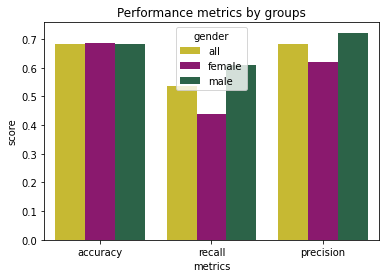

In [101]:
metrics_per_group(y_test, y_pred)

We can see from the plot above that precision and recall are both higher for males, while accuracy is slightly higher for females.

### Fairness Metrics

Fairness metrics help to determine to what extent biases are reflected in our model. It is complicated to define fairness explicitly according to a mathematical definition, so in this section, we explore several different methods for measuring fairness and discuss the implications of each one with regard to our model.

Although there are other variables in our data that could be considered "protected" such as income level, education, and age, we are focusing on gender as the protected attribute of focus for now.

#### Statistical Parity Difference: Equalizes outcomes across groups.

This metric computes the difference in percentages between the "privileged" and "non-privileged" group of individuals who were predicted to have the desired outcome. In this case, it is essentially (% of females who were predicted to have access to emergency funds) - (% of males who were predicted to have access to emergency funds). The "ideal" value is 0 because if we define fairness as statistical parity, the goal would be for the percentages to be equal for both groups. If the value is negative, that means that the percentage of individuals with the positive outcome is higher for the privileged group (males), implying that the model is biased in favor of the priviledged group. Conversely, if the value is positive, the model is biased in favor of the unprivileged group. The acceptable range in which the model is considered fair is between -0.1 to 0.1 (with percentages expressed as decimals, e.g. 0.1 = 10%). It is important to note that this metric is solely focused on making the percentage of *predicted* favorable outcomes equal across groups and does not take into account the accuracy of the predictions at all.

In [102]:
stat_par_diff = statistical_parity_difference(y_test, prot_attr='gender')

print(f'[Baseline] The statistical parity difference is {stat_par_diff: .2}')

[Baseline] The statistical parity difference is -0.13


Since the statistical parity value for our model is -0.13, it is slightly biased against females, but it is fairly close to being fair because it is only slightly out of the fairness range. 

#### Equal Opportunity Difference: Equalizes likelihood of positive outcome across groups.

This metric is simlar to statistical parity in that it is also a group fairness metric, but it is different in that it takes into account accuracy of the model in addition to equalizing outcomes across groups. Instead of measuring the simple differences in percentages between groups of individuals with the (predicted)positive outcome, it measures the difference in percentages of *accurately identified* individuals with positive outcomes (i.e. true positives). Essentially, the calculation is the same as for statistical parity, but only taking into account true positives for each group. Again, the "ideal" value is 0 with negative values indicating bias in favor of the privileged group, and the fairness range is -0.1 to -0.1.

In [103]:
eq_opp_diff = equal_opportunity_difference(y_test, y_pred, prot_attr='gender')

print(f'[Baseline] The equal opportunity difference is {eq_opp_diff: .2}')

[Baseline] The equal opportunity difference is -0.17


Since the equal opportunity value for our model is -0.17, this means that the model is slightly biased in favor of males, and it is slightly outside the range of being considered fair.

#### Generalized entropy error: Equalizes Benefits

This metric is an individual metric rather than a group metric, and it computes fairness by computing the level of unfair benefit being assigned by the model. The metric defines "benefit" as follows: for any individual in the testing data set, that individual has received a benefit if the model predicted the favorable outcome when the truth was that the individual did not have the favorable outcome (i.e. a false positive). Each individual in the data receives either a 2 (benefit, false positive), a 1 (no benefit, correct prediction), or 0 (no benefit, false negative). The metric then compares the benefit of each individual to the average accuracy and false positive level of the model. The "ideal" value is 0, and a higher number indicates a higher level of inquity in benefit among individuals. In other words, if many individuals have a benefit score that is far off from the average, that indicates that the model is unfairly benefitting some individuals and not others. This metric does not consider privileged versus unprivileged groups, and thus is not able to indicate whether or not the inequality in benefit is systematic in any particular way (i.e., it cannot tell whether males receive more benefit than females; it can only tell that some individuals receive higher benefits than others).

In [104]:
gen_entr_error = generalized_entropy_error(y_test, y_pred, alpha=1)

print(f'[Baseline] The generalized entropy error is {gen_entr_error: .2}')

[Baseline] The generalized entropy error is  0.27


A score of 0.27 is fairly high, indicating that there is a high level of inequity in benefit among individuals. I suspect that this number may be this high simply because the model currently has an extremely high number of false positives in general.

#### Disparate impact

The disparate impact metric measures the proportion of positive outcomes between an unprivilaged group and a privilaged group. It is usually assessed when predicting an outcome that disproportionately affects a subpopulation. For example, hiring more men than women as constrution workers on the basis of height and strength.For this case we want to know the proportion of females that are categorized as having access to emergency funds VS males who are categorized as having access to emergency funds.The standard for satisfying this metric is that the unprivilaged group must receive a positive outcome at a ratio of 4:5 to the privilaged group. As long as females are classified as having access to emergency funds no less than around 80% of the time males are categorized as having access to emergency funds, then our model satisfies this metric. 

A similar problem arises when assessing this metric as statistical parity.In reality women have less access to emergency funds than men. If we manipulate our model to satisfy this metric, we will falsely predict that women have access to emergency funds when they don't. This could be more harmful than not satisfying this metric.

[Disparate Treatment & Disparate Impact: What’s the Difference?](https://factorialhr.com/blog/disparate-treatment/)

[AI Fairness — Explanation of Disparate Impact Remover](https://towardsdatascience.com/ai-fairness-explanation-of-disparate-impact-remover-ce0da59451f1)


𝑃𝑟(𝑌̂=pos_label|𝐷=unprivileged) / 𝑃𝑟(𝑌̂=pos_label|𝐷=privileged)

In [105]:
dir = disparate_impact_ratio(y_test,y_pred=y_pred, prot_attr='gender', priv_group=1)
print(f'[Baseline] The disparate impact ratio is {dir: .2}')

[Baseline] The disparate impact ratio is  0.62


The ratio is very close to 80% meaning that the model predicts positive outcomes only 20% less of the time for females than males. Our model satisfies this metric.

#### Consistency score

Are similar people treated similarly. Is our model consistent in the way it classifies people as having access to emergency funds? This metric alone wont tell us if our model is fair but we can see how different groups of people are generally treated. We split the consistency score by gender and we can see if our model is more consistent for men or women. Are individuals within each group being treated similarly? With the other metrics in mind we can determine if they are being treated similarly unfairly or similarly fair. This metric is calculated on a scale from 0 to 1 where a value of 1 means completely consistent. 

http://proceedings.mlr.press/v28/zemel13.html

In [106]:
# entire dataset
cs = consistency_score(X, y, n_neighbors=5)
print(f'[Baseline] The overall consistency score is {cs: .2}')

[Baseline] The overall consistency score is  0.62


In [107]:
X_test_female = X_test[(X_test['gender']==0)]

In [108]:
# gender scores
csf = consistency_score(X_test_female,y_pred_female , n_neighbors=5)
print(f'[Baseline] The consistency score for women is {csf: .2}')

[Baseline] The consistency score for women is  0.7


In [109]:
X_test_males = X_test[(X_test['gender']==1)]

In [110]:
# male scores
csm = consistency_score(X_test_males,y_pred_male , n_neighbors=5)

print(f'[Baseline] The consistency score for men is {csm: .2}')

[Baseline] The consistency score for men is  0.62


Females are treated more consistently. Since the model is also slightly unfair to them this means they are consistently treated unfairly and males are consistintly treated fairly.

#### Conditional Demographic Disparity
Statistical parity difference and equal opportunity difference both measure positive outcomes. The conditional demographic disparity measures negative outcomes. Demographic Disparity is a metric that examines how disadvantaged groups compare to advantaged groups for negative outcomes from the model.This metric checks if a subpopulation is classified with a negative outcome more than a positive outcome. Are females classified as not having access to emergency funds more often than men? Looking at the entire data set, women have less access than men to emergency funds. Predicting more negative outcomes for women than men is not necessarily a bad thing. We want to know if someone doesn't have access to emergency funds so that they can potentially be helped. 

Sometimes when we split data into categories we can find patterns that don't exist when the data is combined. This is called Simpsons paradox [@mehrabi2021survey]. We can see this in our confusion matrices. When our data is split by gender there are different prediction rates than the entire model. The true negative rates are heavily weighted by females, and the true positive rates are weighted towards males. Is this the Simpsons paradox or does gender split the data into different distributions? The Conditional Demographic Disparity metric accounts for the Simpsons paradox to confirm true differences or no differences in negative outcomes in the model.

The range of scores for this metric is from -1 to 1. In general a positive value means that the model is more unfair towards the unprivileged group. A value of zero is ideal. In our case, if our model were to predict an equal proportion of negative and positive outcomes for men and women, our model would realistically be unfair to women. Women do have less access to emergency funds and predicting that men and women equally don't have access to emergency funds might put women at a greater disadvantage if a relief program were to be put in place. However, if assessing financial stability between men and women we would be more concerned with satisfying this metric.  


https://towardsdatascience.com/simpsons-paradox-and-interpreting-data-6a0443516765

https://medium.com/@corymaklin/pretraining-data-bias-18e1d1dfc350

In [111]:
cdd = conditional_demographic_disparity(y_test, y_pred=y_pred, prot_attr='gender', pos_label=1, sample_weight=None)
print(f'[Baseline] The conditional demographic disparity is {cdd: .2}')

[Baseline] The conditional demographic disparity is  0.0026


### Meta Metrics

In this section we will look at metrics about the metrics. We will decompose the generalized entropy error to find the differneces between subgroups of the population. For now we will look at gender. We will also explore the precision of our model and how that precision differs by gender. 

####Difference in Generalized entropy error for females and males.
The general entropy error cannot tell whether males receive more benefit than females so we calculate the general entropy error difference between males and females. Do men "benefit" from our model more i.e does our model predict more accurate and false positives for men than women? Again the interpretation of this metric will depend on the context. A higher score is given for false positives, but this means a group of people are being predicted to have emergency funds when they don't. It is not necessarily a good thing for any group to "benefit" from our model. A value of 0 represents no difference.

In [112]:
gen_entr_diff = difference(generalized_entropy_error, y_test, y_pred=y_pred, prot_attr='gender', priv_group=1)
print(f'[Baseline] The difference in generalized entropy error is{gen_entr_diff: .2}')

[Baseline] The difference in generalized entropy error is 0.0071


The difference is around -.02 meaning that females have a lower generalized entropy error than males by -.02 units. 

After running this metric we can see that females have a lower generalized entropy error meaning they receive less benefit than males. Males receive more false positives than females. This can be seen visually in the side by side confusion matrices shown earlier.

##### Between Group Generalized Entropy Error:

We explored generalized entropy error and how it differs for males and females. Using the between group generalized error metric we will be able to see if the between group unfairness or the individual unfairness dominates. Is there truly a difference in generalized entropy error between men and women or is the general entropy error not due to gender inequality. Is our model unfairly benefiting individuals based on sub populations or is the inequity equal between groups and differs at the individual level?

We don't want generalized entropy error in our model, but it would be better to have it at the individual level than the group level. We don't want either men or women to have more generalized entropy error than the other. If the error is equally within the groups, then both men and women are at a similar "benefit" to each other.



[A Unified Approach to Quantifying Algorithmic Unfairness: Measuring Individual &Group Unfairness via Inequality Indices](https://dl.acm.org/doi/10.1145/3219819.3220046)


[Generalized entropy error](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-post-training-bias-metric-ge.html)

In [113]:
bet_grp_entr = between_group_generalized_entropy_error(y_test, y_pred, prot_attr='gender', priv_group=1)
print(f'[Baseline] The between groups generalized entropy error is{bet_grp_entr: .2}')

[Baseline] The between groups generalized entropy error is 0.00015


This metric is very small meaning that there is more variation in error within the male and female groups than between. We found a difference between the error for males and females, but this difference is very small compared to the overall variation of benefit within these groups. 

### Fairness Metrics Summary

The table below summarizes the fairness metrics for the baseline model as compared to the "objective" (or ideal value) for each metric.

In [114]:
objective_metrics = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
baseline_metrics = get_fairness_metrics(y_test, y_pred, prot_attr = 'gender')

techniques = ['objective', 'baseline']
metrics = [objective_metrics, baseline_metrics]

metrics_table = generate_metrics_table(techniques, metrics)
metrics_table

,technique,accuracy,precision,prec_diff,stat_par_diff,eq_opp_diff,gen_entr_error,disp_impact,gen_entr_diff,bet_grp_gen_entr,cond_dem_disparity
0,objective,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,baseline,0.684000,0.682000,-0.103000,-0.161000,-0.170000,0.269000,0.625000,0.007000,0.000000,0.003000


The plot below displays the fairness metrics as compared to the objective values visually.

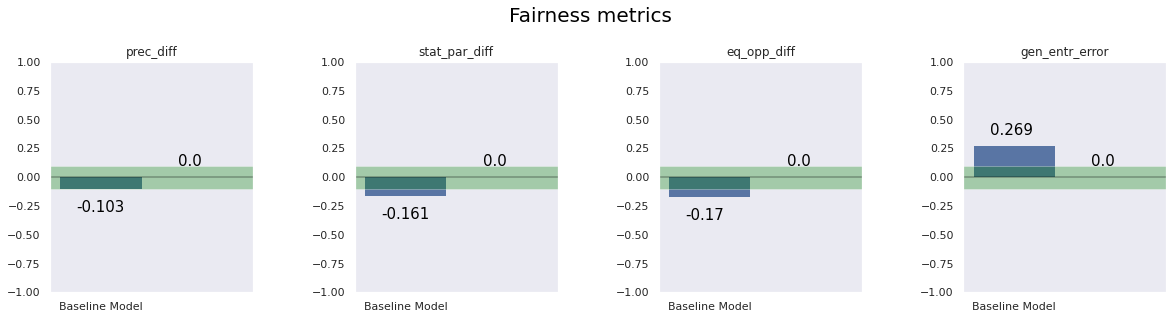

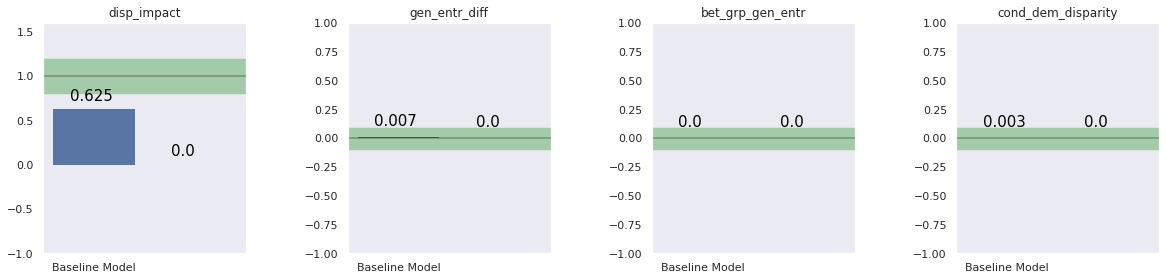

In [115]:
fair_metrics_mitigated = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
plot_fair_metrics(fair_metrics_mitigated, '')

# Rebalancing Data

It is important to consider the aspects of our data that could be sensitive or confidential and ensure that we are intentional about how that data is used in our predictive model. The purpose of processing techniques is to modify either the structure of the data or the functionality of the model such that the predicted outcomes are more equitable. In our data the main variables that could be considered sensitive are gender, age, and education level. There are also several financial variables that could be considered sensitive including income quantile, whether or not an individual has a bank account, and whether or not an individual is in the workforce. However, there is no information that is strictly personally identifiable or confidential such as account numbers or ID numbers. Since the data is anonomized and is not personally identifiable, it is able to be maintained in a public database for an indefinite amount of time. We are choosing to focus only on the protected attribute of gender for this analysis.

In the following sections, we explore various pre-processing, in-processing, and post-processing techniques with the intention of increasing the fairness of the model with respect to gender. After applying each technique, we re-assess the fairness metrics. 

## Reweighting

Reweighting is a pre-processing technique which assigns weights such that the protected attribute (gender) becomes statistically independent from the outcome variable (access to emergency funds). This means that after reweighting, knowing the gender of an individual does not provide any information about whether or not the individual has access. In mathematical terms, P(gender = male and access = yes) = P(gender = male)*P(access = yes), and this equality holds true for all gender-access combinations.

In [116]:
from aif360.sklearn.preprocessing import ReweighingMeta, Reweighing
rew = ReweighingMeta(estimator=clf2, reweigher=Reweighing('gender'))
rew.fit(X_train, y_train)
y_pred_REW = rew.predict(X_test)

In [117]:
acc_REW = accuracy_score(y_test, y_pred_REW)
print(f'[Reweighting] The test accuracy of the algorithm is: {acc_REW: .2%}')

[Reweighting] The test accuracy of the algorithm is:  68.89%


Confusion Matrix

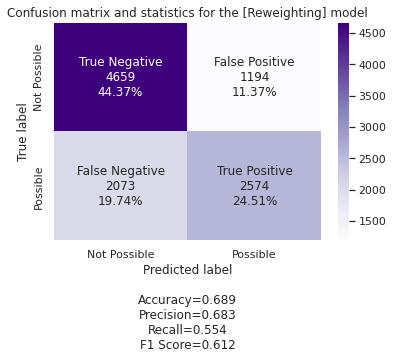

In [118]:
cf_matrix = confusion_matrix(y_test, y_pred_REW)
make_confusion_matrix(cf_matrix, "[Reweighting]")

The confusion matrix is similar to that of the baseline model.

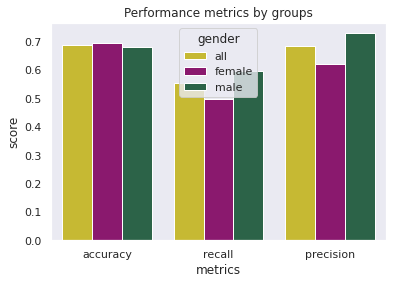

In [119]:
metrics_per_group(y_test, y_pred_REW)

It appears that precision and recall are still slightly higher for males, while accuracy is slightly higher for females.

## Fairness Metrics Summary

In [120]:
rw_metrics = get_fairness_metrics(y_test, y_pred_REW, prot_attr = 'gender')

techniques = ['objective', 'baseline', 'reweighting']
metrics = [objective_metrics, baseline_metrics, rw_metrics]

generate_metrics_table(techniques, metrics)

,technique,accuracy,precision,prec_diff,stat_par_diff,eq_opp_diff,gen_entr_error,disp_impact,gen_entr_diff,bet_grp_gen_entr,cond_dem_disparity
0,objective,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,baseline,0.684000,0.682000,-0.103000,-0.161000,-0.170000,0.269000,0.625000,0.007000,0.000000,0.003000
2,reweighting,0.689000,0.683000,-0.109000,-0.114000,-0.101000,0.259000,0.727000,-0.012000,0.000000,0.002000


The plot below shows the comparison between the fairness metrics after reweigthing as compared to the baseline. For the most part, the metrics are fairly similar, indicating that reweighting may not be the most effective technique for improving the fairness of the model.

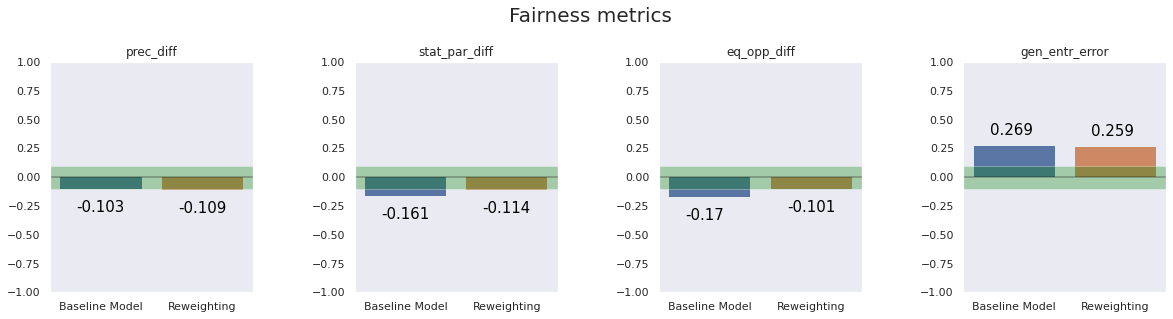

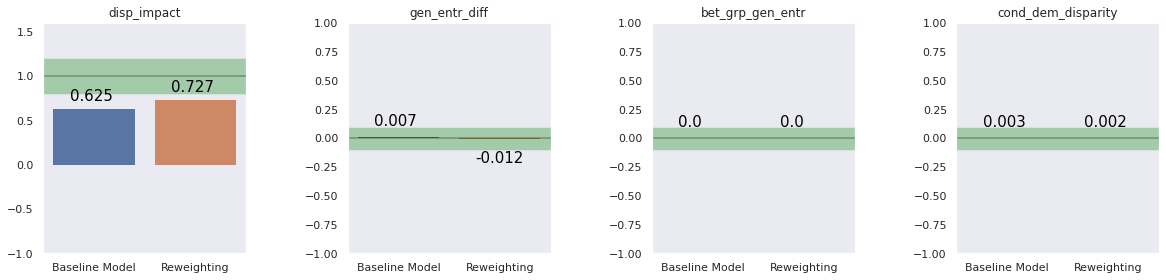

In [121]:
plot_fair_metrics(rw_metrics[2:10], 'Reweighting')

# In-Processing (Classifier): Optimization Approach

## Questions to ask



* What measures of model performance are being reported, and why were they selected over other measures of model performance?

For the Confusion Matrix and Meta Classification Model, we have True Negatives, False Positives, False Negatives, and True Positives.  

* How are the measurements and estimations of these metrics calculated? For example, this may include standard deviation, variance, confidence intervals, or KL divergence. 



<details><summary>Additional questions:</summary>
   <p> 
      
* If decision thresholds are used, what are they, and why were those decision thresholds chosen?

* What datasets were used to evaluate the model? Why?
* How did the model perform on Quantitative analyses should provide the results of evaluating the model according to the chosen metrics, providing confidence interval values when possible.
* Have we tested model results for fairness with respect to different affected groups (e.g., tested for disparate error rates)?
* Have we considered the effects of optimizing for our defined metrics and considered additional metrics?
* Can we explain in understandable terms a decision the model made in cases where a justification is needed?

   </p>
</details>

## Questions to ask

* What type of model is it? 
 * This includes basic model architecture details, such as whether it is a Naive Bayes classifier, Convolutional Neural Network, etc. 
* Is the model intended to inform decisions about matters central to human life or flourishing – e.g., health or safety? Or could it be used in such a way?
* Does the model use any sensitive data (e.g., protected classes)?
* Have we ensured that the model does not rely on variables or proxies for variables that are unfairly discriminatory?

<details><summary>Additional questions:</summary>
   <p> 
      
*  What person or organization developed the model and When?
 * What is an email address that people may write to for further information?
* What risks may be present in model usage? Try to identify the potential recipients, likelihood, and magnitude of harms
* What risk mitigation strategies were used during model development?
 * Ex. strategies used for transparency and interpretability, feature engineering, data quality control, hyperparameter tuning etc.

   </p>
</details>





## Meta Fair Classifier

The meta fair classifier creates a new estimator but includes a reweighing pre-processing step. This classifier should be used as part of a pipeline of steps. We must create a binary label data set. This means that the data includes either a 1 representing access to emergency funds or 0 for no access to emergency funds. This classifier aims to transform the data in a way that will satisfy as many fairness metrics as possible.

In [122]:
# combine the features with the predicted label, and rename the sensitive attribute column

df_train = X_train.copy()
df_train["has_access"] = y_train
df_train.rename(columns={None:'gender'}, inplace=True)
df_train = df_train.reset_index(drop=True)

df_test = X_test.copy()
df_test["has_access"] = y_test
df_test = df_test.reset_index(drop=True)
df_test.rename(columns={None:'gender'}, inplace=True)

In [123]:
# To use AIF360's Disparate Impact Remover, we need to create a BinaryLabelDataset for the training and testing data
train_BLD = BinaryLabelDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=df_train,
                                label_names=['has_access'],
                                protected_attribute_names=['gender'])

test_BLD = BinaryLabelDataset(favorable_label='1',
                                unfavorable_label='0',
                                df=df_test,
                                label_names=['has_access'],
                                protected_attribute_names=['gender'])

In [124]:
%%capture --no-display
meta = MetaFairClassifier(tau=0.8, sensitive_attr='gender', type='fdr', seed=1234567)

meta.fit(train_BLD)
y_pred_META = meta.predict(test_BLD)
y_pred_META = y_pred_META.labels.flatten()

**Metrics**

In [125]:
acc_AD = accuracy_score(y_test, y_pred_META)
print(f'[ Meta-Classification] The test accuracy of the algorithm is: {acc_AD: .2%}')

[ Meta-Classification] The test accuracy of the algorithm is:  55.33%


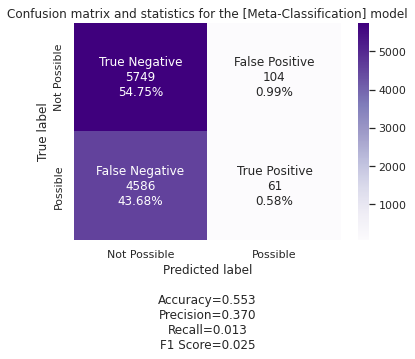

In [126]:
cf_matrix = confusion_matrix(y_test, y_pred_META)
make_confusion_matrix(cf_matrix, "[Meta-Classification]")

In [127]:
print(y_pred_META.size)
np.count_nonzero(y_pred_META)
print(f'Non zero values in META {np.count_nonzero(y_pred_META)} and in base {np.count_nonzero(y_test)}')

10500
Non zero values in META 165 and in base 4647


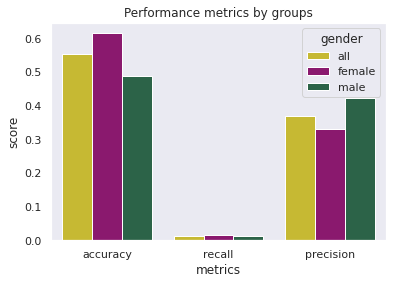

In [128]:
metrics_per_group(y_test, y_pred_META)

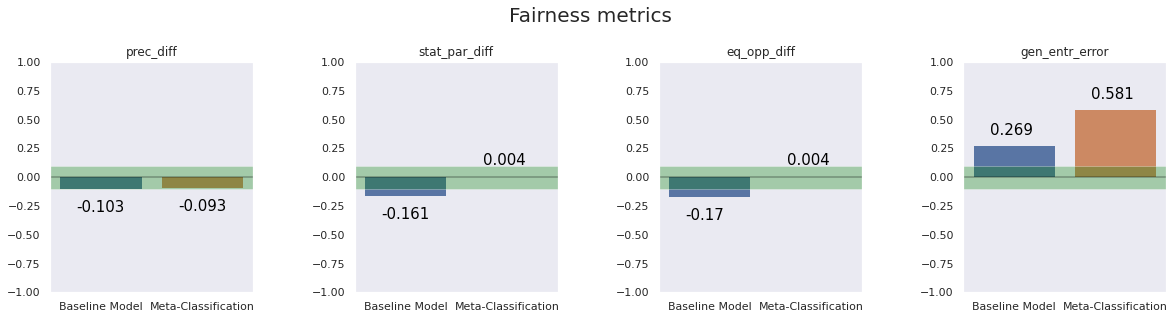

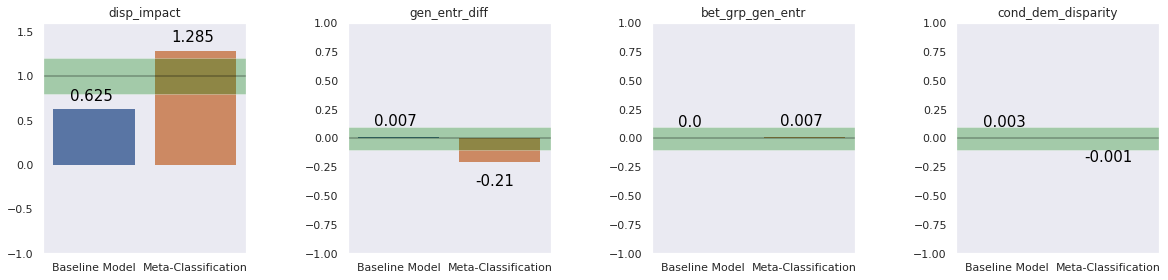

In [129]:
meta_metrics = get_fairness_metrics(y_test, y_pred_META, prot_attr = 'gender')
plot_fair_metrics(meta_metrics[2:10], 'Meta-Classification')

## Exponentiated Gradient Reduction

The exponentiation gradient reduction is an in-processing optimization approach. This processor aims to optimize both accuracy and fairness focusing on demographic parity and equalized odds. The algorithm this processor uses considers randomized classifiers and cost restraints to find the optimal classifier that satisfies fairness restraints without losing too much accuracy. 

In [130]:
from aif360.sklearn.inprocessing import ExponentiatedGradientReduction, GridSearchReduction, AdversarialDebiasing
clf = DecisionTreeClassifier()

egr = ExponentiatedGradientReduction('gender', estimator = clf2, constraints = "EqualizedOdds")
new_preds = egr.fit(X_train, y_train).predict(X_test)

In [131]:
new_acc = accuracy_score(y_test, new_preds)
print(f'[Exponentiated Gradient Reduction] The test accuracy of the algorithm is: {new_acc: .2%}')

[Exponentiated Gradient Reduction] The test accuracy of the algorithm is:  66.84%


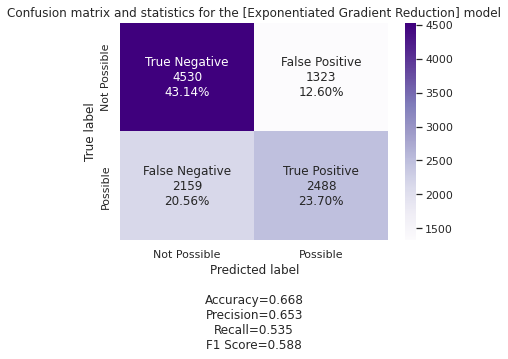

In [132]:
cf_matrix = confusion_matrix(y_test, new_preds)
make_confusion_matrix(cf_matrix, "[Exponentiated Gradient Reduction]")

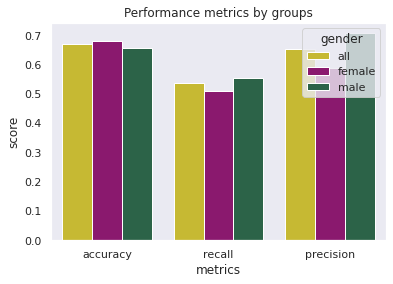

In [133]:
metrics_per_group(y_test, new_preds)

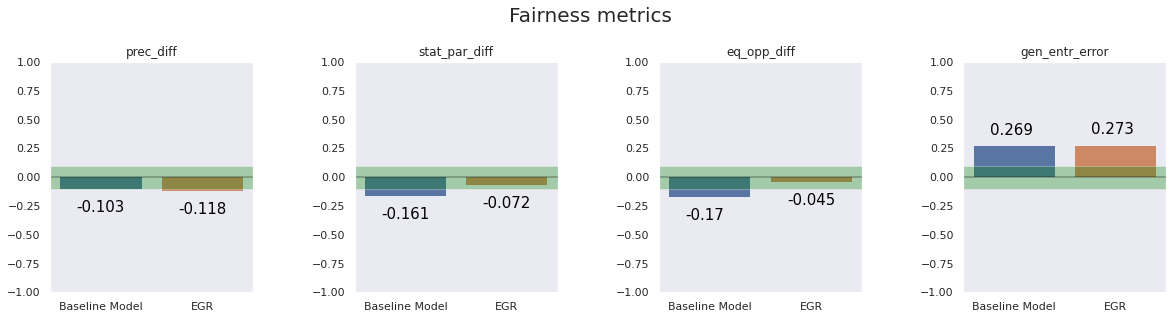

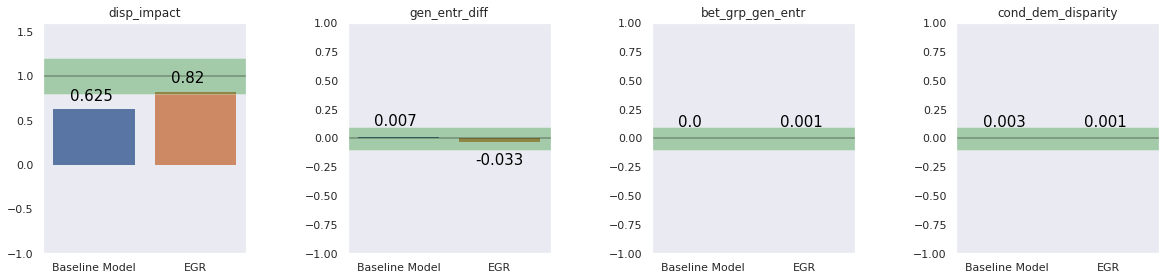

In [134]:
egr_metrics = get_fairness_metrics(y_test, new_preds, prot_attr = 'gender')
plot_fair_metrics(egr_metrics[2:10], 'EGR')

## Grid Search Reduction

Grid search reduction uses the cost restraint lamda to find a balance between fairness and accuracy. This processor searches over a grid of lamda values until the best value is found. This value is used in the classifier to satisfy fairness and maximize accuracy. The grid search reduction is useful for binary sensitive attributes and fairness metrics with minimal constraints like demographic parity and equalized odds.

In [135]:
clf = DecisionTreeClassifier()

gsr = GridSearchReduction('gender', estimator = clf2, constraints = "EqualizedOdds")
new_preds = gsr.fit(X_train, y_train).predict(X_test)

In [136]:
new_acc = accuracy_score(y_test, new_preds)
print(f'[Grid Search Reduction] The test accuracy of the algorithm is: {new_acc: .2%}')

[Grid Search Reduction] The test accuracy of the algorithm is:  66.79%


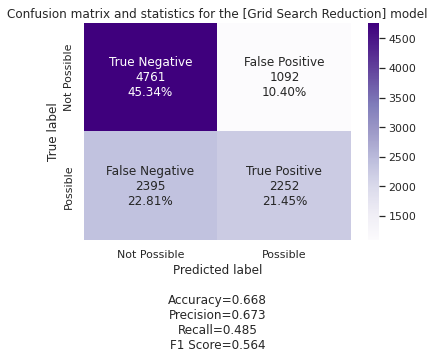

In [137]:
cf_matrix = confusion_matrix(y_test, new_preds)
make_confusion_matrix(cf_matrix, "[Grid Search Reduction]")

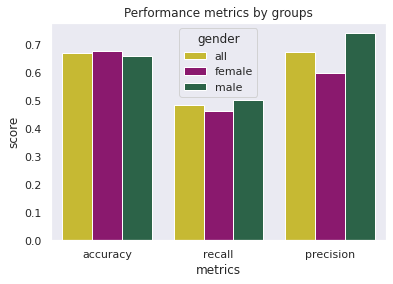

In [138]:
metrics_per_group(y_test, new_preds)

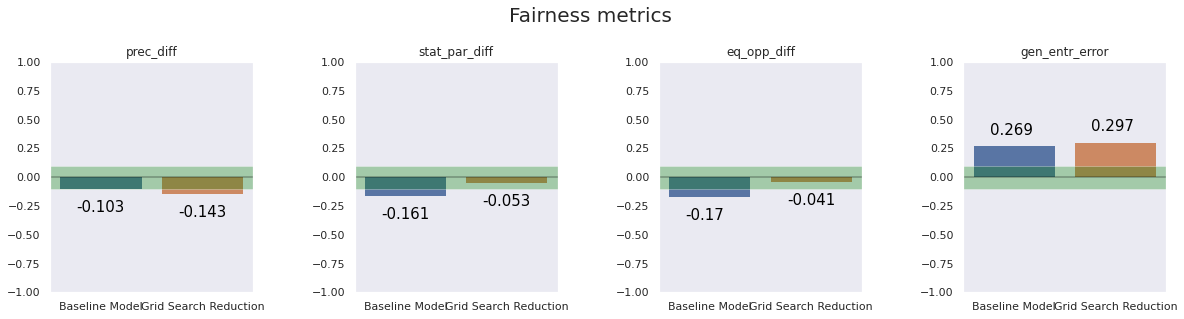

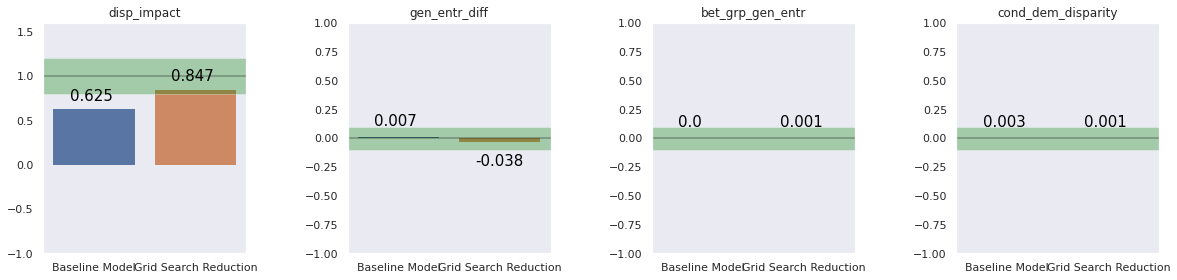

In [139]:
gsr_metrics = get_fairness_metrics(y_test, new_preds, prot_attr = 'gender')
plot_fair_metrics(gsr_metrics[2:10], 'Grid Search Reduction')

## Fairness Metrics Summary

In [140]:
techniques = ['objective', 'baseline', 'reweighting', 'meta fair classifier', 'exponential gradient reduction', 'grid search reduction']
metrics = [objective_metrics, baseline_metrics, rw_metrics, meta_metrics, egr_metrics, gsr_metrics]

generate_metrics_table(techniques, metrics)

,technique,accuracy,precision,prec_diff,stat_par_diff,eq_opp_diff,gen_entr_error,disp_impact,gen_entr_diff,bet_grp_gen_entr,cond_dem_disparity
0,objective,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,baseline,0.684000,0.682000,-0.103000,-0.161000,-0.170000,0.269000,0.625000,0.007000,0.000000,0.003000
2,reweighting,0.689000,0.683000,-0.109000,-0.114000,-0.101000,0.259000,0.727000,-0.012000,0.000000,0.002000
3,meta fair classifier,0.553000,0.370000,-0.093000,0.004000,0.004000,0.581000,1.285000,-0.210000,0.007000,-0.001000
4,exponential gradient reduction,0.668000,0.653000,-0.118000,-0.072000,-0.045000,0.273000,0.820000,-0.033000,0.001000,0.001000
5,grid search reduction,0.668000,0.673000,-0.143000,-0.053000,-0.041000,0.297000,0.847000,-0.038000,0.001000,0.001000


# Post-Processing (Prediction): Control 




## Calibrated Equalized Odds

Calibrated equalized odds uses a post-processing technique that re classifies values to satisfy the equalized odds metric while keeping the classifier calibrated. A classifier is calibrated if the proportions of positive and negative outcomes in the data match the probabilities produced by the model. We want the calibration to hold across groups such as male and female. This processor aims to satisfy an equalized cost constraint while maintaining calibration.

In [141]:
# dataset
# train model
# add the reject opinion based classification algorithm
# evaluate on fairness metrics

from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta, RejectOptionClassifier, RejectOptionClassifierCV

pp = CalibratedEqualizedOdds('gender', cost_constraint='weighted', random_state=1234567)
ceo = PostProcessingMeta(estimator=clf2, postprocessor=pp, random_state=1234567)
ceo.fit(X_train, y_train)
y_pred_CEO = ceo.predict(X_test)
y_proba_CEO = ceo.predict_proba(X_test)

In [142]:
acc_CEO = accuracy_score(y_test, y_pred_CEO)
print(f'[Calibrated Equalized Odds] The test accuracy of the algorithm is: {acc_CEO: .2%}')

[Calibrated Equalized Odds] The test accuracy of the algorithm is:  68.07%


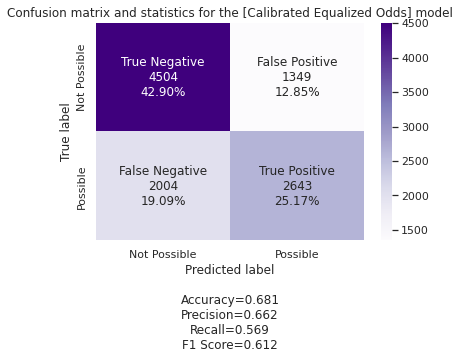

In [143]:
cf_matrix = confusion_matrix(y_test, y_pred_CEO)
make_confusion_matrix(cf_matrix, "[Calibrated Equalized Odds]")

This confusion matrix shows us an overall accuarcy of around 68%, precision of 66% and recall of 56%. 

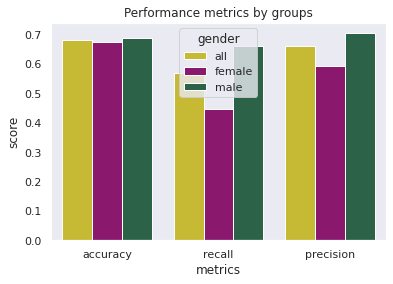

In [144]:
metrics_per_group(y_test, y_pred_CEO)

Here we see that we have similar accuracy among both groups, but males have higher recall and precision. This means that our model correctly predicts the amount of negative and positive outcomes for males more often than it correctly predicts the same outcomes for females. 

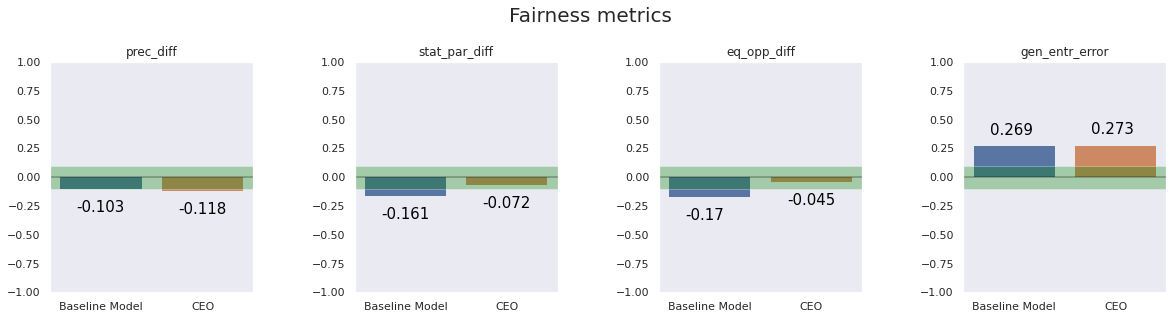

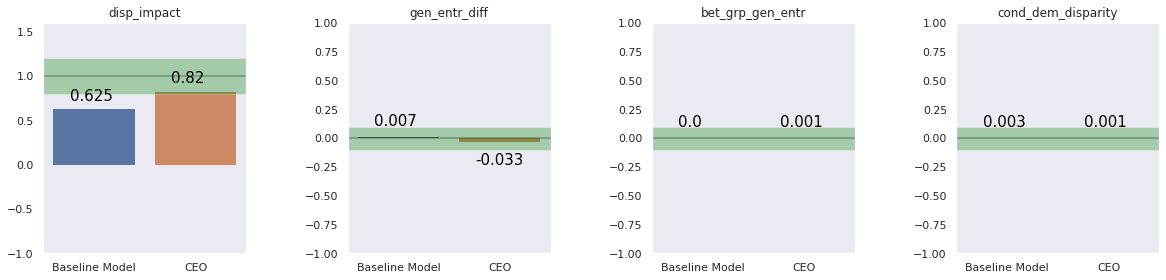

In [145]:
ceo_metrics = get_fairness_metrics(y_test, y_pred_CEO, prot_attr = 'gender')
plot_fair_metrics(egr_metrics[2:10], 'CEO')

Our statistical parity difference, equal oppourtunity difference, general entropy error difference, between group general entrop error difference and conditional demographic disparity all seem to be within the acceptable range. The statistical parity differnce, equal oppourtunity difference and conditional demographic disparity have improved compared to  our baseline model. Our precision difference, disparate impact, and general entropy error were not within the acceptable range, indicating that one of our groups (males) benefits from our model and that our other group (females) is predicted to have access to emergency funds when they in fact do not. 

## Reject Option Classifier

The reject option classifier is a post-processor that aims to reduce discriminatory classifications based on the sensitive attribute. In our case we aim to find a balance for predictions between males and females. This classifier will relabel observations in a way that reduces discrimination. More males will be relabeled with the unfavorable outcome and more females will be relabeled with the favorable outcome.

In [146]:
pr = RejectOptionClassifier('gender', threshold = 0.5, margin = 0.1)
roc = PostProcessingMeta(estimator=clf2, postprocessor=pr, random_state=1234567)
roc.fit(X_train, y_train)
y_pred_ROC = roc.predict(X_test)
y_proba_ROC = roc.predict_proba(X_test)

In [147]:
acc_ROC = accuracy_score(y_test, y_pred_ROC)
print(f'[Reject Option Classifier] The test accuracy of the algorithm is: {acc_ROC: .2%}')

[Reject Option Classifier] The test accuracy of the algorithm is:  67.07%


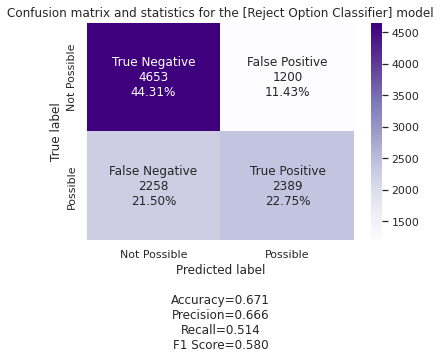

In [148]:
cf_matrix = confusion_matrix(y_test, y_pred_ROC)
make_confusion_matrix(cf_matrix, "[Reject Option Classifier]")

This confusion matrix shows us an accuacy of 67%, precision of 66%, and recall of 51%. 

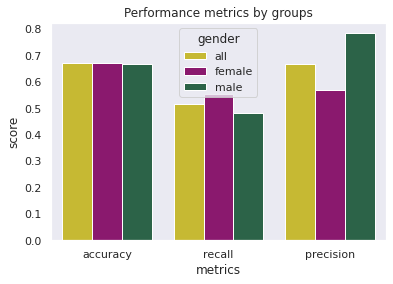

In [149]:
metrics_per_group(y_test, y_pred_ROC)

There is similar accuracy among both groups. Males have higher precision while females have higher recall. This means that our model correctly predicts the amount of positve outcomes more often for males than it does females, but correctly predicts the amount of negative outcomes more often for females than it does males. 

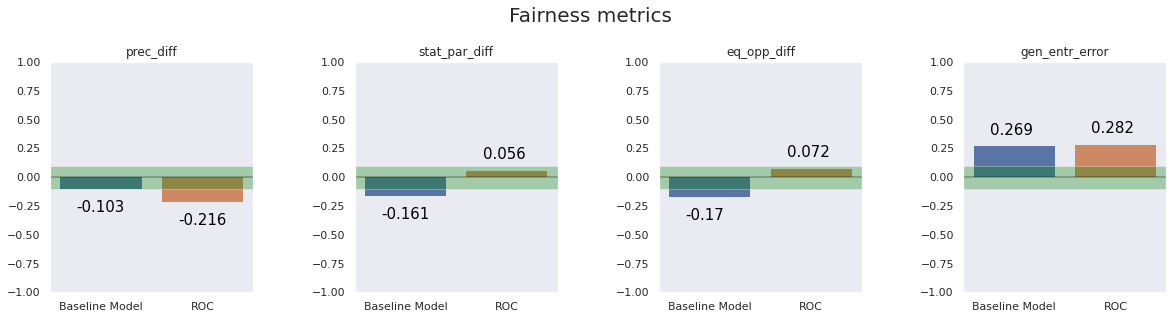

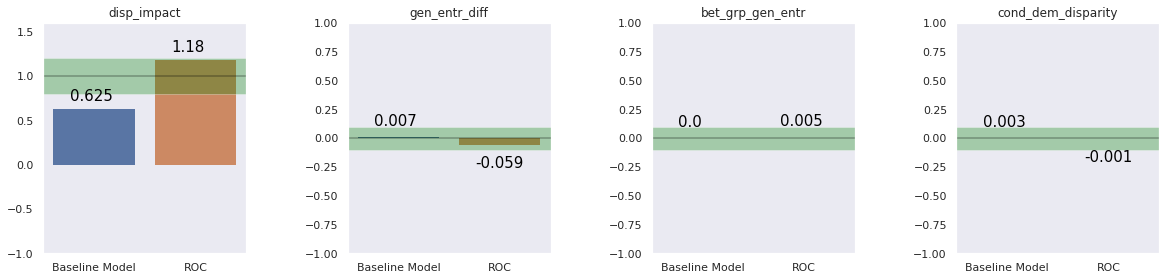

In [150]:
roc_metrics = get_fairness_metrics(y_test, y_pred_ROC, prot_attr = 'gender')
plot_fair_metrics(roc_metrics[2:10], 'ROC')

Our statistical parity difference, equal oppourtunity difference, general entropy error difference, between group general entrop error difference and conditional demographic disparity all seem to be within the acceptable range. However, only the statistical parity differnce, equal oppourtunity difference and conditional demographic disparity have improved compared to  our baseline model. Our precision difference, disparate immpact, and general entropy error were not within the acceptable range, indicating that one of our groups benefits from our model and that our other group is predicted to have access to emergency funds when they in fact do not. 

## Fairness Metrics Summary

In [151]:
techniques = ['objective', 'baseline', 'reweighting', 'meta fair classifier', 'exponential gradient reduction', 'grid search reduction', 'calibrated equalized odds', 'reject option classifier']
metrics = [objective_metrics, baseline_metrics, rw_metrics, meta_metrics, egr_metrics, gsr_metrics, ceo_metrics, roc_metrics]

generate_metrics_table(techniques, metrics)

,technique,accuracy,precision,prec_diff,stat_par_diff,eq_opp_diff,gen_entr_error,disp_impact,gen_entr_diff,bet_grp_gen_entr,cond_dem_disparity
0,objective,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,baseline,0.684000,0.682000,-0.103000,-0.161000,-0.170000,0.269000,0.625000,0.007000,0.000000,0.003000
2,reweighting,0.689000,0.683000,-0.109000,-0.114000,-0.101000,0.259000,0.727000,-0.012000,0.000000,0.002000
3,meta fair classifier,0.553000,0.370000,-0.093000,0.004000,0.004000,0.581000,1.285000,-0.210000,0.007000,-0.001000
4,exponential gradient reduction,0.668000,0.653000,-0.118000,-0.072000,-0.045000,0.273000,0.820000,-0.033000,0.001000,0.001000
5,grid search reduction,0.668000,0.673000,-0.143000,-0.053000,-0.041000,0.297000,0.847000,-0.038000,0.001000,0.001000
6,calibrated equalized odds,0.681000,0.662000,-0.113000,-0.193000,-0.217000,0.254000,0.596000,0.027000,0.001000,0.003000
7,reject option classifier,0.671000,0.666000,-0.216000,0.056000,0.072000,0.282000,1.180000,-0.059000,0.005000,-0.001000
